In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/PRUEBA A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=172.1, y1=127.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 502
Page 1, Q1, A: Yellow percentage: 0.0%


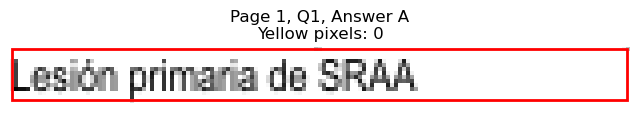

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=174.6, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 531
Page 1, Q1, B: Yellow percentage: 0.0%


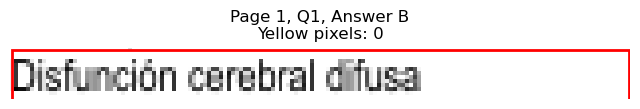

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=428.3, y1=127.3
Page 1, Q1, C: Yellow pixels: 152
Page 1, Q1, C: Total non-white pixels: 677
Page 1, Q1, C: Yellow percentage: 22.5%


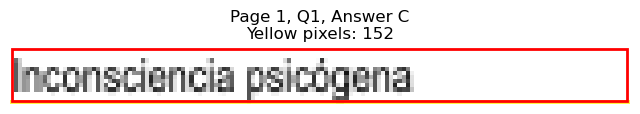

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=496.1, y1=139.9
Page 1, Q1, D: Yellow pixels: 2120
Page 1, Q1, D: Total non-white pixels: 2782
Page 1, Q1, D: Yellow percentage: 76.2%


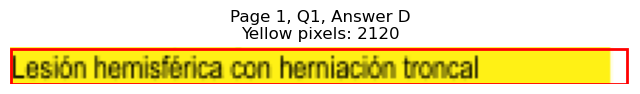


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=80.9, y1=190.4
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 60
Page 1, Q2, A: Yellow percentage: 0.0%


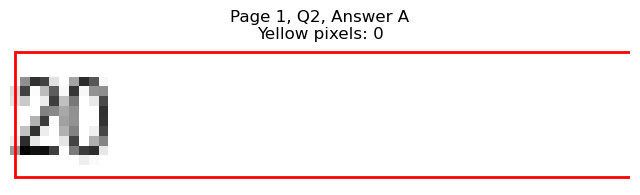

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=65.2, y1=203.0
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 74
Page 1, Q2, B: Yellow percentage: 0.0%


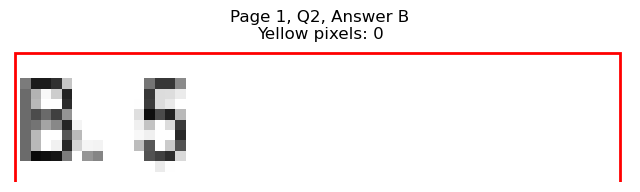

Page 1, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=340.1, y1=190.4
Page 1, Q2, C: Yellow pixels: 737
Page 1, Q2, C: Total non-white pixels: 896
Page 1, Q2, C: Yellow percentage: 82.3%


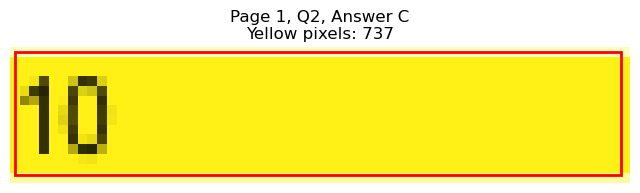

Page 1, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=324.4, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 122
Page 1, Q2, D: Yellow percentage: 0.0%


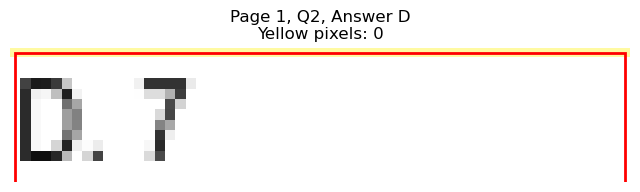


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=96.4, y1=253.5
Page 1, Q3, A: Yellow pixels: 923
Page 1, Q3, A: Total non-white pixels: 1106
Page 1, Q3, A: Yellow percentage: 83.5%


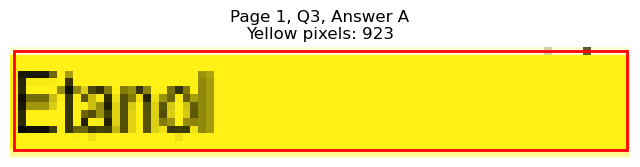

Page 1, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=119.4, y1=266.1
Page 1, Q3, B: Yellow pixels: 102
Page 1, Q3, B: Total non-white pixels: 355
Page 1, Q3, B: Yellow percentage: 28.7%


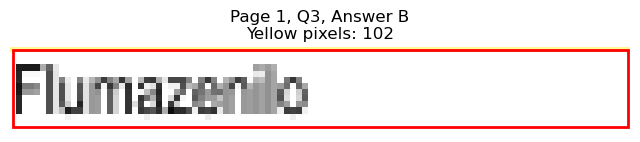

Page 1, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=363.7, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 200
Page 1, Q3, C: Yellow percentage: 0.0%


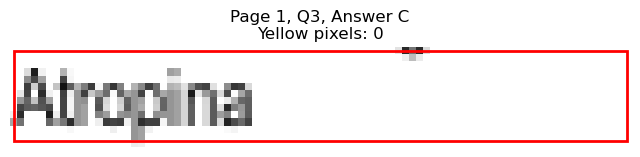

Page 1, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=373.1, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 226
Page 1, Q3, D: Yellow percentage: 0.0%


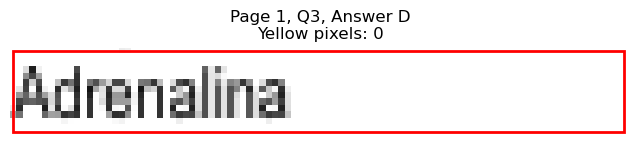


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=125.4, y1=329.3
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 289
Page 1, Q4, A: Yellow percentage: 0.0%


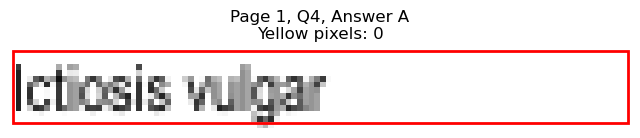

Page 1, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=156.1, y1=341.9
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 461
Page 1, Q4, B: Yellow percentage: 0.0%


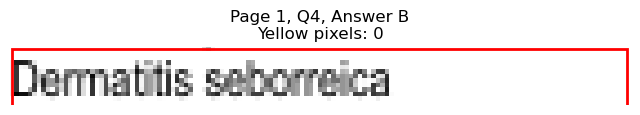

Page 1, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=402.3, y1=329.3
Page 1, Q4, C: Yellow pixels: 1199
Page 1, Q4, C: Total non-white pixels: 1764
Page 1, Q4, C: Yellow percentage: 68.0%


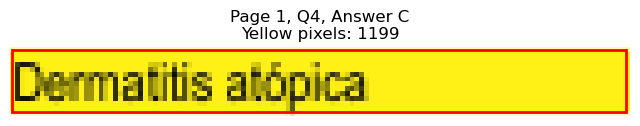

Page 1, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=397.7, y1=341.9
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 460
Page 1, Q4, D: Yellow percentage: 0.0%


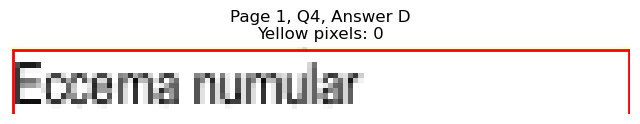


Page 1, Q4 - Selected Answer: C (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=133.0, y1=392.4
Page 1, Q5, A: Yellow pixels: 115
Page 1, Q5, A: Total non-white pixels: 448
Page 1, Q5, A: Yellow percentage: 25.7%


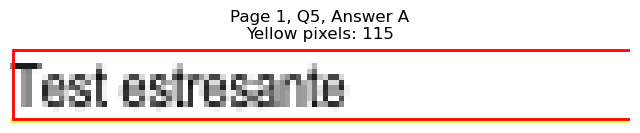

Page 1, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=141.5, y1=405.0
Page 1, Q5, B: Yellow pixels: 1326
Page 1, Q5, B: Total non-white pixels: 1612
Page 1, Q5, B: Yellow percentage: 82.3%


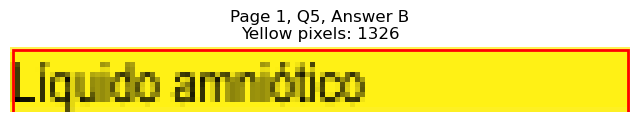

Page 1, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=411.3, y1=392.4
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 448
Page 1, Q5, C: Yellow percentage: 0.0%


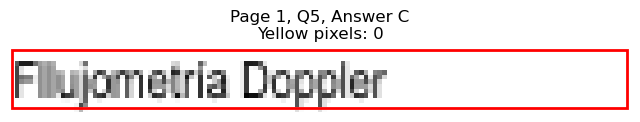

Page 1, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=399.3, y1=405.0
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 379
Page 1, Q5, D: Yellow percentage: 0.0%


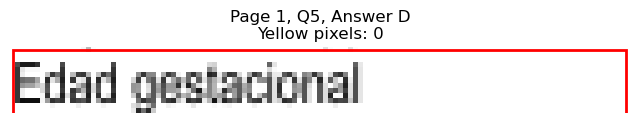


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=145.6, y1=468.1
Page 1, Q6, A: Yellow pixels: 128
Page 1, Q6, A: Total non-white pixels: 483
Page 1, Q6, A: Yellow percentage: 26.5%


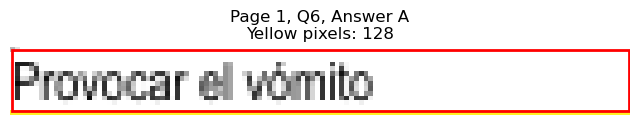

Page 1, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=195.3, y1=480.7
Page 1, Q6, B: Yellow pixels: 1856
Page 1, Q6, B: Total non-white pixels: 2314
Page 1, Q6, B: Yellow percentage: 80.2%


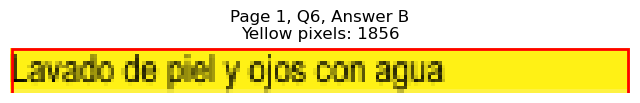

Page 1, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=393.8, y1=468.1
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 317
Page 1, Q6, C: Yellow percentage: 0.0%


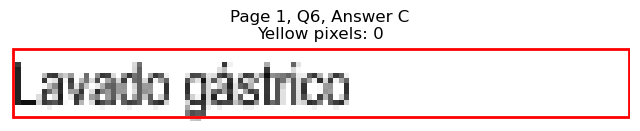

Page 1, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=395.7, y1=480.7
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 342
Page 1, Q6, D: Yellow percentage: 0.0%


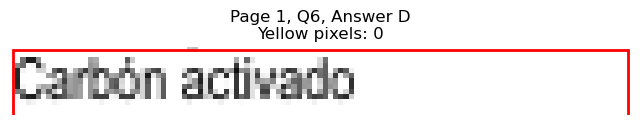


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=158.5, y1=543.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 472
Page 1, Q7, A: Yellow percentage: 0.0%


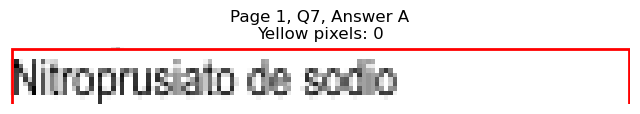

Page 1, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=115.9, y1=556.4
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 244
Page 1, Q7, B: Yellow percentage: 0.0%


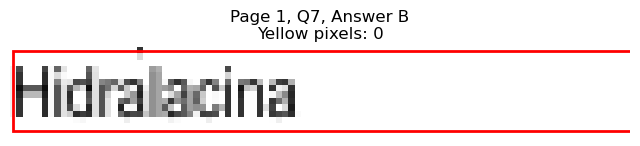

Page 1, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=382.7, y1=543.8
Page 1, Q7, C: Yellow pixels: 1143
Page 1, Q7, C: Total non-white pixels: 1378
Page 1, Q7, C: Yellow percentage: 82.9%


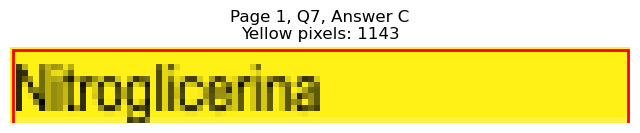

Page 1, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=375.2, y1=556.4
Page 1, Q7, D: Yellow pixels: 95
Page 1, Q7, D: Total non-white pixels: 358
Page 1, Q7, D: Yellow percentage: 26.5%


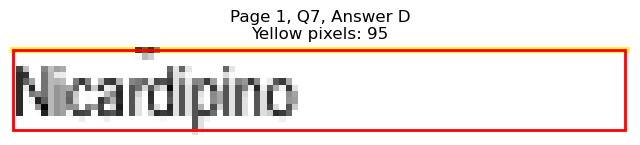


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=149.3, y1=594.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 367
Page 1, Q8, A: Yellow percentage: 0.0%


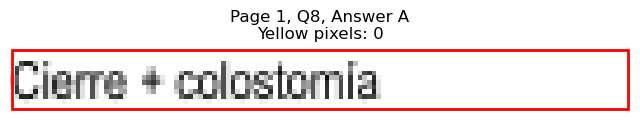

Page 1, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=135.5, y1=607.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 370
Page 1, Q8, B: Yellow percentage: 0.0%


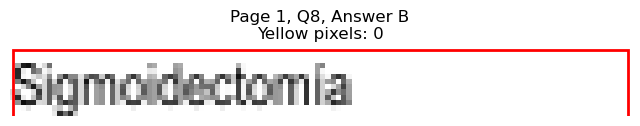

Page 1, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=378.2, y1=594.4
Page 1, Q8, C: Yellow pixels: 102
Page 1, Q8, C: Total non-white pixels: 343
Page 1, Q8, C: Yellow percentage: 29.7%


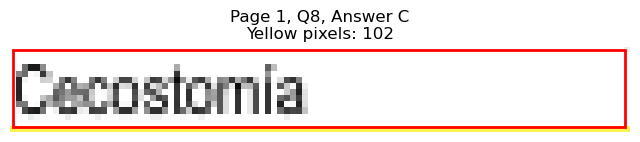

Page 1, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=383.2, y1=607.0
Page 1, Q8, D: Yellow pixels: 1161
Page 1, Q8, D: Total non-white pixels: 1391
Page 1, Q8, D: Yellow percentage: 83.5%


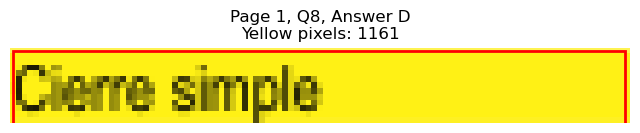


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=179.7, y1=670.1
Page 1, Q9, A: Yellow pixels: 1684
Page 1, Q9, A: Total non-white pixels: 2268
Page 1, Q9, A: Yellow percentage: 74.3%


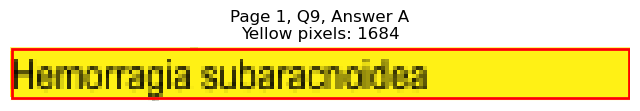

Page 1, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=132.0, y1=682.7
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 395
Page 1, Q9, B: Yellow percentage: 0.0%


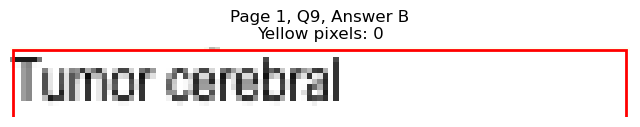

Page 1, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=390.8, y1=670.1
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 324
Page 1, Q9, C: Yellow percentage: 0.0%


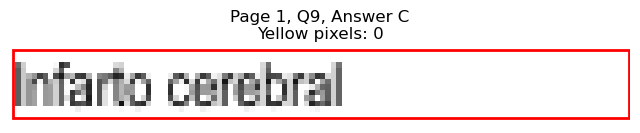

Page 1, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=398.2, y1=682.7
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 391
Page 1, Q9, D: Yellow percentage: 0.0%


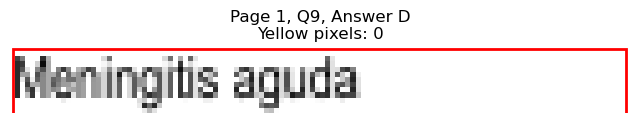


Page 1, Q9 - Selected Answer: A (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=149.1, y1=745.8
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 427
Page 1, Q10, A: Yellow percentage: 0.0%


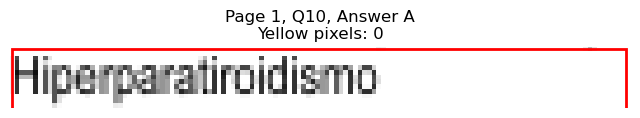

Page 1, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=177.6, y1=758.4
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 558
Page 1, Q10, B: Yellow percentage: 0.0%


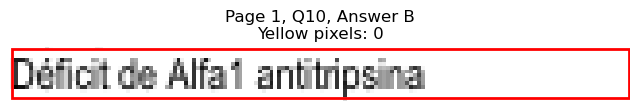

Page 1, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=402.3, y1=745.8
Page 1, Q10, C: Yellow pixels: 1343
Page 1, Q10, C: Total non-white pixels: 1638
Page 1, Q10, C: Yellow percentage: 82.0%


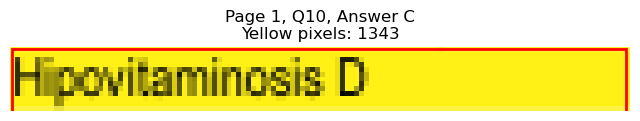

Page 1, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=385.3, y1=758.4
Page 1, Q10, D: Yellow pixels: 109
Page 1, Q10, D: Total non-white pixels: 408
Page 1, Q10, D: Yellow percentage: 26.7%


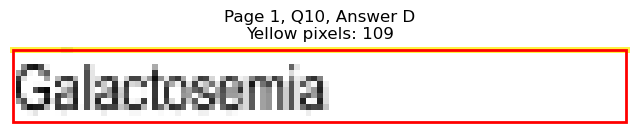


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=204.8, y1=139.9
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 689
Page 2, Q1, A: Yellow percentage: 0.0%


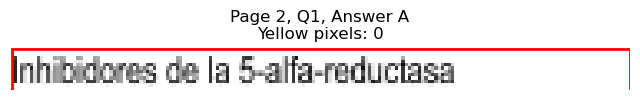

Page 2, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=187.2, y1=152.6
Page 2, Q1, B: Yellow pixels: 1726
Page 2, Q1, B: Total non-white pixels: 2380
Page 2, Q1, B: Yellow percentage: 72.5%


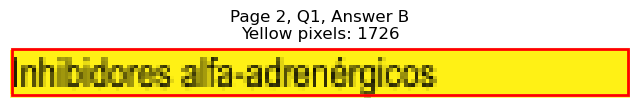

Page 2, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=468.0, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 713
Page 2, Q1, C: Yellow percentage: 0.0%


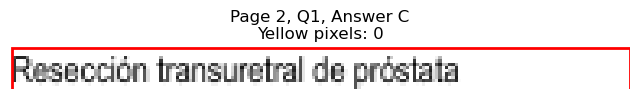

Page 2, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=442.4, y1=152.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 610
Page 2, Q1, D: Yellow percentage: 0.0%


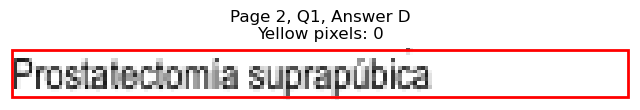


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=228.3, x1=160.1, y1=240.9
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 430
Page 2, Q2, A: Yellow percentage: 0.0%


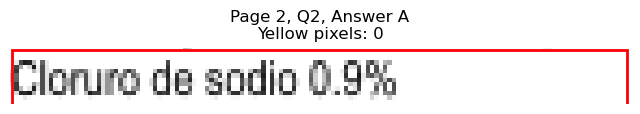

Page 2, Q2 - B: Detected box: x0=68.3, y0=240.9, x1=132.0, y1=253.5
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 312
Page 2, Q2, B: Yellow percentage: 0.0%


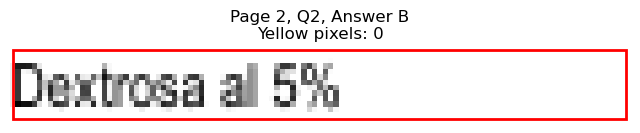

Page 2, Q2 - C: Detected box: x0=327.5, y0=228.3, x1=424.4, y1=240.9
Page 2, Q2, C: Yellow pixels: 1566
Page 2, Q2, C: Total non-white pixels: 1924
Page 2, Q2, C: Yellow percentage: 81.4%


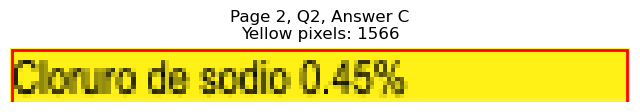

Page 2, Q2 - D: Detected box: x0=327.5, y0=240.9, x1=401.2, y1=253.5
Page 2, Q2, D: Yellow pixels: 125
Page 2, Q2, D: Total non-white pixels: 486
Page 2, Q2, D: Yellow percentage: 25.7%


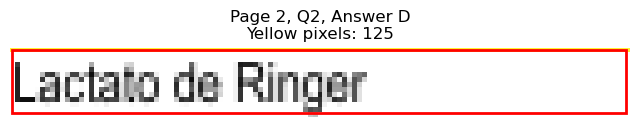


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=304.0, x1=121.5, y1=316.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 276
Page 2, Q3, A: Yellow percentage: 0.0%


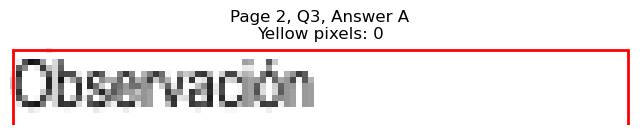

Page 2, Q3 - B: Detected box: x0=68.3, y0=316.6, x1=175.6, y1=329.3
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 526
Page 2, Q3, B: Yellow percentage: 0.0%


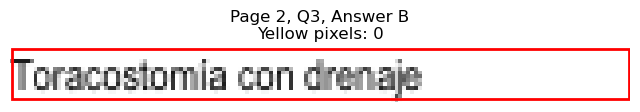

Page 2, Q3 - C: Detected box: x0=327.5, y0=304.0, x1=434.3, y1=316.7
Page 2, Q3, C: Yellow pixels: 5
Page 2, Q3, C: Total non-white pixels: 705
Page 2, Q3, C: Yellow percentage: 0.7%


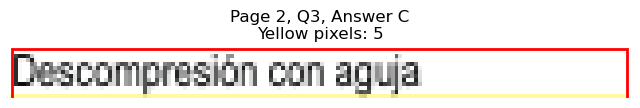

Page 2, Q3 - D: Detected box: x0=327.5, y0=316.6, x1=430.9, y1=329.3
Page 2, Q3, D: Yellow pixels: 1448
Page 2, Q3, D: Total non-white pixels: 2156
Page 2, Q3, D: Yellow percentage: 67.2%


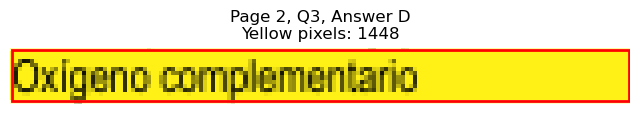


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=392.3, x1=131.5, y1=405.0
Page 2, Q4, A: Yellow pixels: 1237
Page 2, Q4, A: Total non-white pixels: 1482
Page 2, Q4, A: Yellow percentage: 83.5%


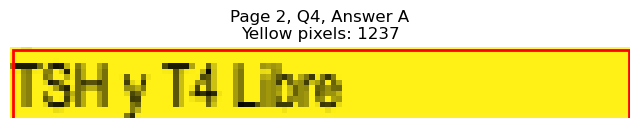

Page 2, Q4 - B: Detected box: x0=68.3, y0=404.9, x1=141.5, y1=417.6
Page 2, Q4, B: Yellow pixels: 122
Page 2, Q4, B: Total non-white pixels: 528
Page 2, Q4, B: Yellow percentage: 23.1%


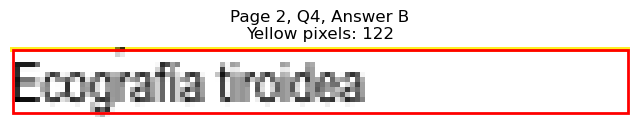

Page 2, Q4 - C: Detected box: x0=327.5, y0=392.3, x1=368.1, y1=405.0
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 173
Page 2, Q4, C: Yellow percentage: 0.0%


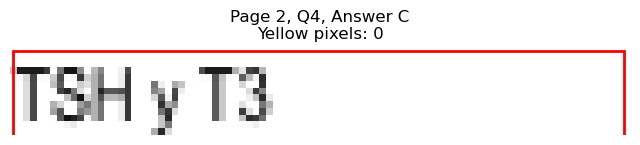

Page 2, Q4 - D: Detected box: x0=327.5, y0=404.9, x1=360.7, y1=417.6
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 125
Page 2, Q4, D: Yellow percentage: 0.0%


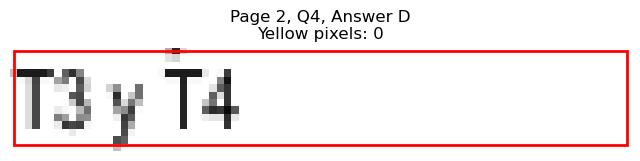


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=468.1, x1=116.4, y1=480.7
Page 2, Q5, A: Yellow pixels: 1100
Page 2, Q5, A: Total non-white pixels: 1287
Page 2, Q5, A: Yellow percentage: 85.5%


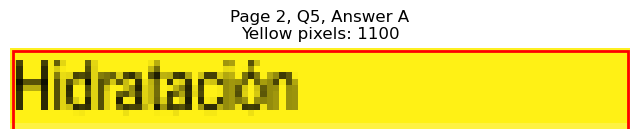

Page 2, Q5 - B: Detected box: x0=68.3, y0=480.8, x1=115.5, y1=493.4
Page 2, Q5, B: Yellow pixels: 98
Page 2, Q5, B: Total non-white pixels: 342
Page 2, Q5, B: Yellow percentage: 28.7%


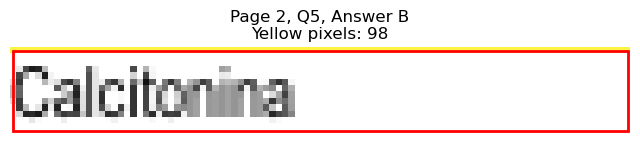

Page 2, Q5 - C: Detected box: x0=327.5, y0=468.1, x1=377.7, y1=480.7
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 257
Page 2, Q5, C: Yellow percentage: 0.0%


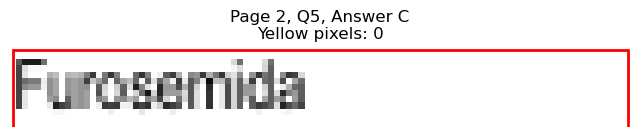

Page 2, Q5 - D: Detected box: x0=327.5, y0=480.8, x1=381.2, y1=493.4
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 266
Page 2, Q5, D: Yellow percentage: 0.0%


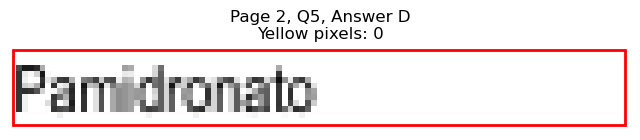


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=109.5, y1=531.2
Page 2, Q6, A: Yellow pixels: 1025
Page 2, Q6, A: Total non-white pixels: 1288
Page 2, Q6, A: Yellow percentage: 79.6%


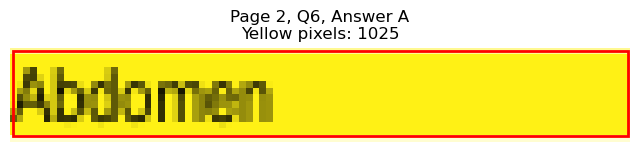

Page 2, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=101.4, y1=543.8
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 247
Page 2, Q6, B: Yellow percentage: 0.0%


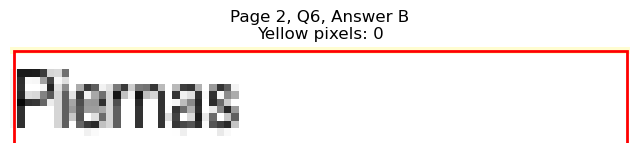

Page 2, Q6 - C: Detected box: x0=327.5, y0=518.6, x1=355.6, y1=531.2
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 145
Page 2, Q6, C: Yellow percentage: 0.0%


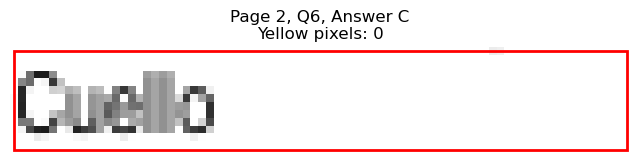

Page 2, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=349.6, y1=543.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 103
Page 2, Q6, D: Yellow percentage: 0.0%


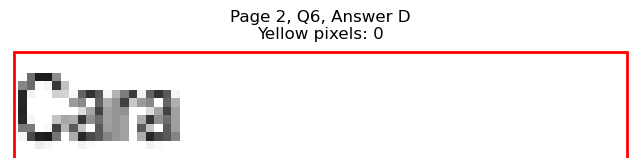


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=594.3, x1=160.1, y1=607.0
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 463
Page 2, Q7, A: Yellow percentage: 0.0%


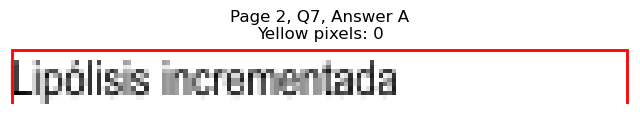

Page 2, Q7 - B: Detected box: x0=68.3, y0=606.9, x1=121.0, y1=619.6
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 294
Page 2, Q7, B: Yellow percentage: 0.0%


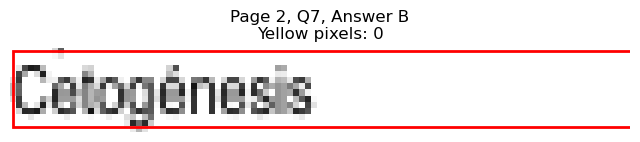

Page 2, Q7 - C: Detected box: x0=327.5, y0=594.3, x1=426.9, y1=607.0
Page 2, Q7, C: Yellow pixels: 1573
Page 2, Q7, C: Total non-white pixels: 1950
Page 2, Q7, C: Yellow percentage: 80.7%


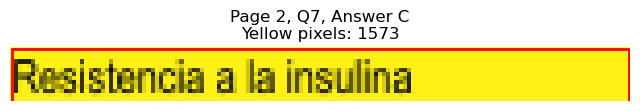

Page 2, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=399.8, y1=619.6
Page 2, Q7, D: Yellow pixels: 123
Page 2, Q7, D: Total non-white pixels: 498
Page 2, Q7, D: Yellow percentage: 24.7%


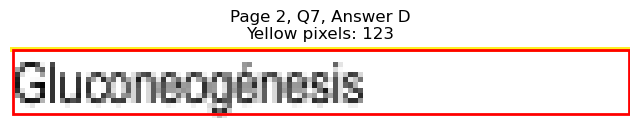


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=56.6, y0=670.1, x1=65.2, y1=682.7
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 103
Page 2, Q8, A: Yellow percentage: 0.0%


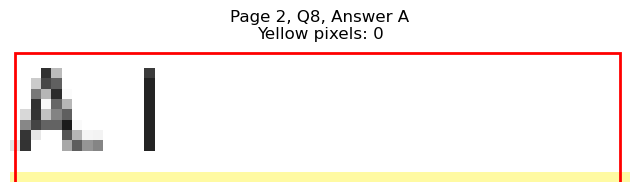

Page 2, Q8 - B: Detected box: x0=68.3, y0=682.7, x1=84.4, y1=695.3
Page 2, Q8, B: Yellow pixels: 750
Page 2, Q8, B: Total non-white pixels: 938
Page 2, Q8, B: Yellow percentage: 80.0%


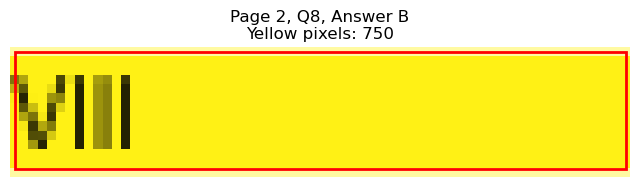

Page 2, Q8 - C: Detected box: x0=327.5, y0=670.1, x1=338.6, y1=682.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 50
Page 2, Q8, C: Yellow percentage: 0.0%


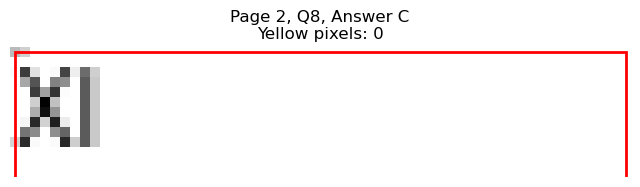

Page 2, Q8 - D: Detected box: x0=315.4, y0=682.7, x1=324.4, y1=695.3
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 88
Page 2, Q8, D: Yellow percentage: 0.0%


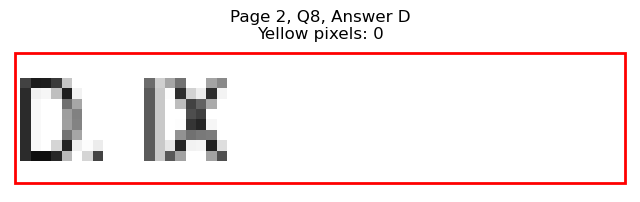


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=120.0, y1=139.9
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 284
Page 3, Q1, A: Yellow percentage: 0.0%


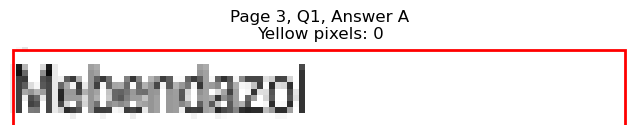

Page 3, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=117.5, y1=152.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 237
Page 3, Q1, B: Yellow percentage: 0.0%


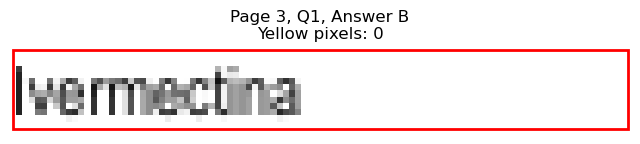

Page 3, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=374.7, y1=139.9
Page 3, Q1, C: Yellow pixels: 1097
Page 3, Q1, C: Total non-white pixels: 1274
Page 3, Q1, C: Yellow percentage: 86.1%


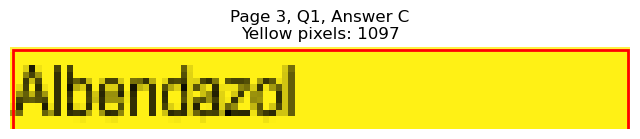

Page 3, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=379.3, y1=152.6
Page 3, Q1, D: Yellow pixels: 103
Page 3, Q1, D: Total non-white pixels: 376
Page 3, Q1, D: Yellow percentage: 27.4%


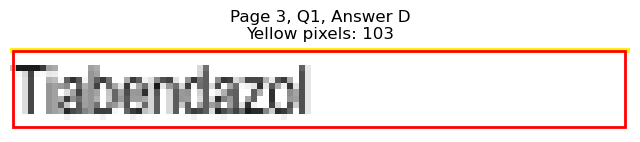


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=112.9, y1=215.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 229
Page 3, Q2, A: Yellow percentage: 0.0%


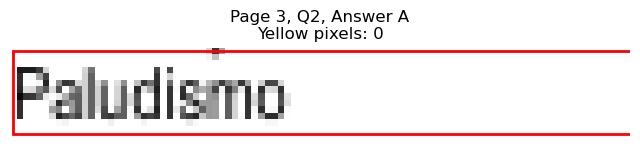

Page 3, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=130.5, y1=228.3
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 316
Page 3, Q2, B: Yellow percentage: 0.0%


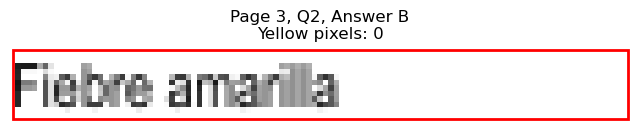

Page 3, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=382.7, y1=215.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 289
Page 3, Q2, C: Yellow percentage: 0.0%


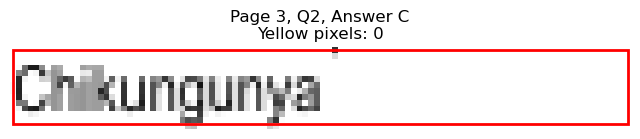

Page 3, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=361.6, y1=228.3
Page 3, Q2, D: Yellow pixels: 872
Page 3, Q2, D: Total non-white pixels: 1190
Page 3, Q2, D: Yellow percentage: 73.3%


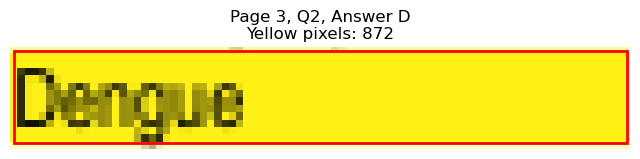


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=133.5, y1=291.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 347
Page 3, Q3, A: Yellow percentage: 0.0%


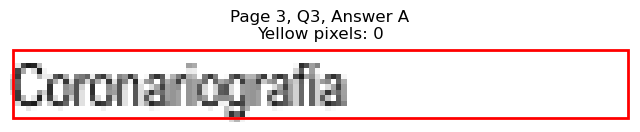

Page 3, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=153.0, y1=304.1
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 455
Page 3, Q3, B: Yellow percentage: 0.0%


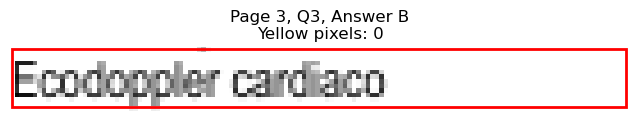

Page 3, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=421.9, y1=291.5
Page 3, Q3, C: Yellow pixels: 145
Page 3, Q3, C: Total non-white pixels: 627
Page 3, Q3, C: Yellow percentage: 23.1%


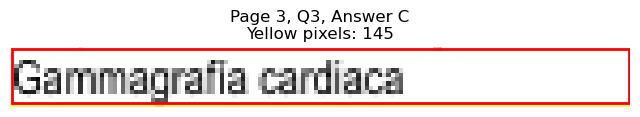

Page 3, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=393.3, y1=304.1
Page 3, Q3, D: Yellow pixels: 1271
Page 3, Q3, D: Total non-white pixels: 1638
Page 3, Q3, D: Yellow percentage: 77.6%


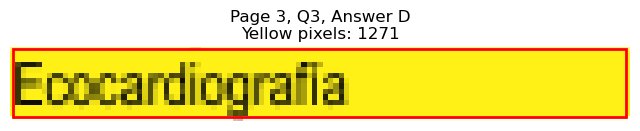


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=351.7, y1=354.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 1382
Page 3, Q4, A: Yellow percentage: 0.0%


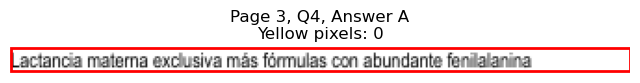

Page 3, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=188.7, y1=367.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 585
Page 3, Q4, B: Yellow percentage: 0.0%


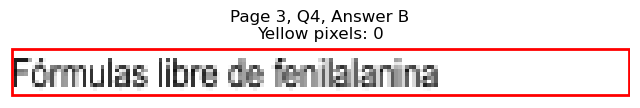

Page 3, Q4 - C: Detected box: x0=68.8, y0=367.1, x1=196.7, y1=379.8
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 836
Page 3, Q4, C: Yellow percentage: 0.0%


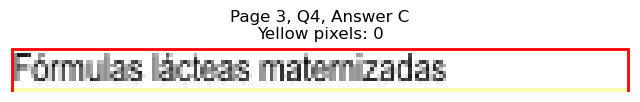

Page 3, Q4 - D: Detected box: x0=68.8, y0=379.7, x1=332.1, y1=392.4
Page 3, Q4, D: Yellow pixels: 2804
Page 3, Q4, D: Total non-white pixels: 4410
Page 3, Q4, D: Yellow percentage: 63.6%


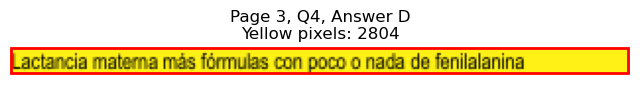


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=115.9, y1=455.5
Page 3, Q5, A: Yellow pixels: 1079
Page 3, Q5, A: Total non-white pixels: 1372
Page 3, Q5, A: Yellow percentage: 78.6%


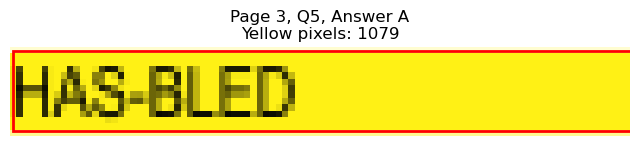

Page 3, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=95.9, y1=468.1
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 142
Page 3, Q5, B: Yellow percentage: 0.0%


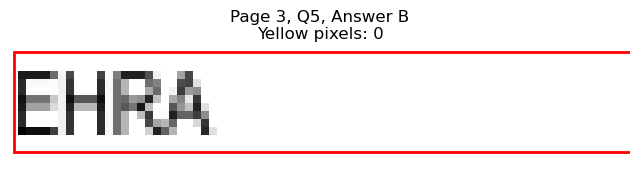

Page 3, Q5 - C: Detected box: x0=365.4, y0=442.8, x1=393.1, y1=455.5
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 127
Page 3, Q5, C: Yellow percentage: 0.0%


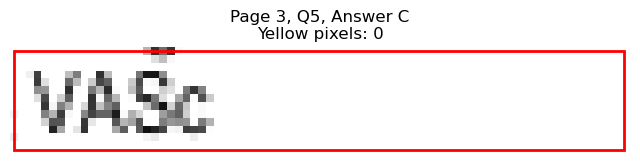

Page 3, Q5 - D: Detected box: x0=327.5, y0=455.5, x1=348.1, y1=468.1
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 100
Page 3, Q5, D: Yellow percentage: 0.0%


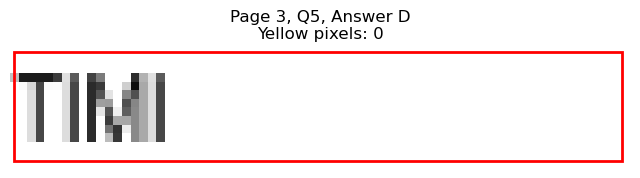


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=120.5, y1=531.2
Page 3, Q6, A: Yellow pixels: 1125
Page 3, Q6, A: Total non-white pixels: 1442
Page 3, Q6, A: Yellow percentage: 78.0%


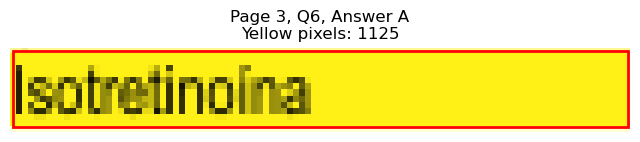

Page 3, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=118.5, y1=543.8
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 351
Page 3, Q6, B: Yellow percentage: 0.0%


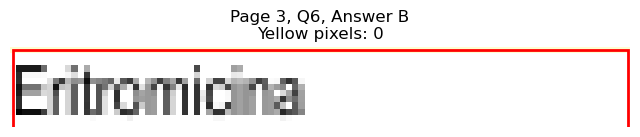

Page 3, Q6 - C: Detected box: x0=327.5, y0=518.6, x1=397.3, y1=531.2
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 363
Page 3, Q6, C: Yellow percentage: 0.0%


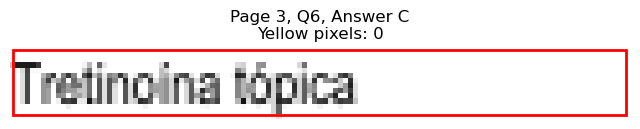

Page 3, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=415.3, y1=543.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 453
Page 3, Q6, D: Yellow percentage: 0.0%


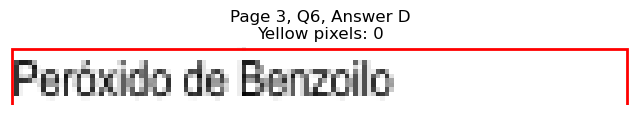


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=172.1, y1=594.4
Page 3, Q7, A: Yellow pixels: 155
Page 3, Q7, A: Total non-white pixels: 686
Page 3, Q7, A: Yellow percentage: 22.6%


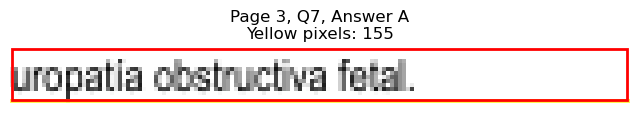

Page 3, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=143.1, y1=607.0
Page 3, Q7, B: Yellow pixels: 1336
Page 3, Q7, B: Total non-white pixels: 1638
Page 3, Q7, B: Yellow percentage: 81.6%


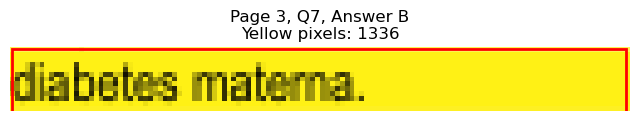

Page 3, Q7 - C: Detected box: x0=327.5, y0=581.7, x1=409.3, y1=594.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 382
Page 3, Q7, C: Yellow percentage: 0.0%


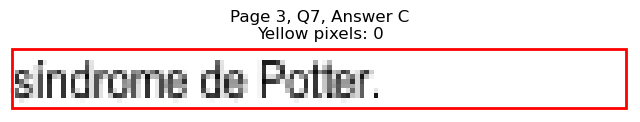

Page 3, Q7 - D: Detected box: x0=327.5, y0=594.3, x1=428.3, y1=607.0
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 516
Page 3, Q7, D: Yellow percentage: 0.0%


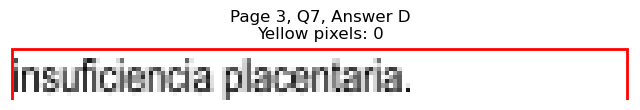


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=262.4, y1=657.5
Page 3, Q8, A: Yellow pixels: 245
Page 3, Q8, A: Total non-white pixels: 1232
Page 3, Q8, A: Yellow percentage: 19.9%


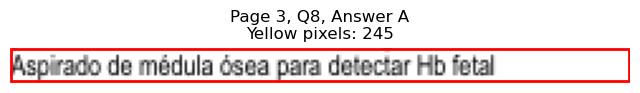

Page 3, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=270.4, y1=670.1
Page 3, Q8, B: Yellow pixels: 2474
Page 3, Q8, B: Total non-white pixels: 3542
Page 3, Q8, B: Yellow percentage: 69.8%


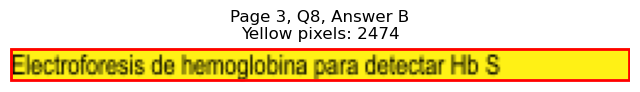

Page 3, Q8 - C: Detected box: x0=68.8, y0=670.1, x1=310.0, y1=682.7
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 1446
Page 3, Q8, C: Yellow percentage: 0.0%


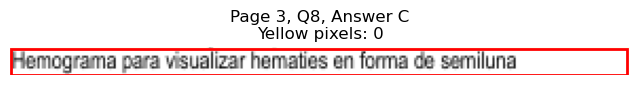

Page 3, Q8 - D: Detected box: x0=68.8, y0=682.7, x1=343.6, y1=695.3
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 1367
Page 3, Q8, D: Yellow percentage: 0.0%


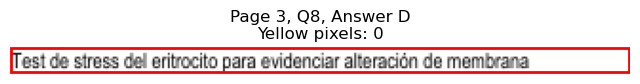


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=218.8, y1=139.9
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 758
Page 4, Q1, A: Yellow percentage: 0.0%


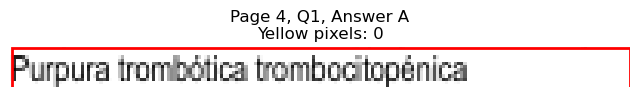

Page 4, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=205.1, y1=152.6
Page 4, Q1, B: Yellow pixels: 1921
Page 4, Q1, B: Total non-white pixels: 2632
Page 4, Q1, B: Yellow percentage: 73.0%


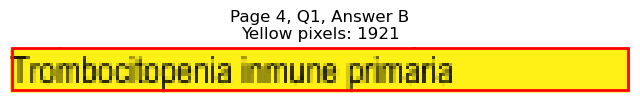

Page 4, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=488.5, y1=139.9
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 803
Page 4, Q1, C: Yellow percentage: 0.0%


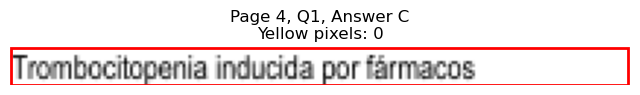

Page 4, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=443.8, y1=152.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 569
Page 4, Q1, D: Yellow percentage: 0.0%


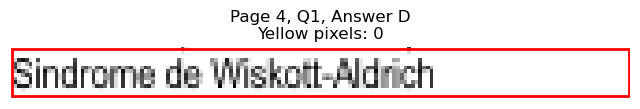


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=103.5, y1=228.3
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 185
Page 4, Q2, A: Yellow percentage: 0.0%


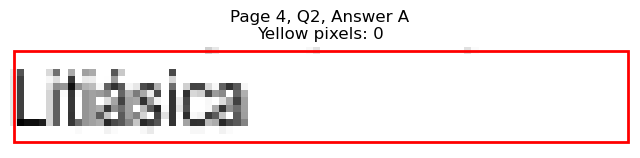

Page 4, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=124.0, y1=240.9
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 259
Page 4, Q2, B: Yellow percentage: 0.0%


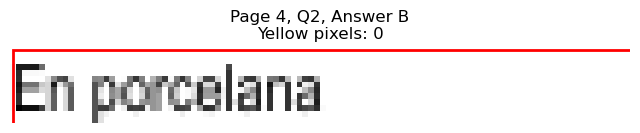

Page 4, Q2 - C: Detected box: x0=327.5, y0=215.7, x1=365.7, y1=228.3
Page 4, Q2, C: Yellow pixels: 917
Page 4, Q2, C: Total non-white pixels: 1246
Page 4, Q2, C: Yellow percentage: 73.6%


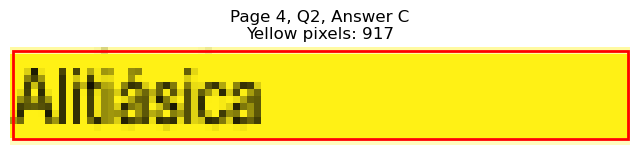

Page 4, Q2 - D: Detected box: x0=327.5, y0=228.3, x1=384.8, y1=240.9
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 393
Page 4, Q2, D: Yellow percentage: 0.0%


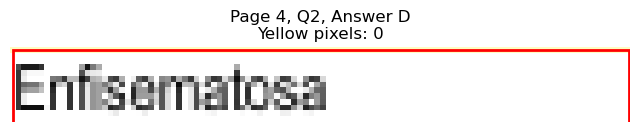


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=176.7, y1=291.5
Page 4, Q3, A: Yellow pixels: 159
Page 4, Q3, A: Total non-white pixels: 700
Page 4, Q3, A: Yellow percentage: 22.7%


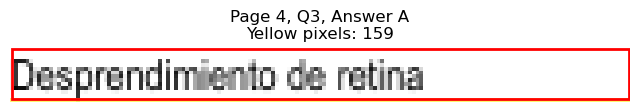

Page 4, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=155.1, y1=304.1
Page 4, Q3, B: Yellow pixels: 1474
Page 4, Q3, B: Total non-white pixels: 1932
Page 4, Q3, B: Yellow percentage: 76.3%


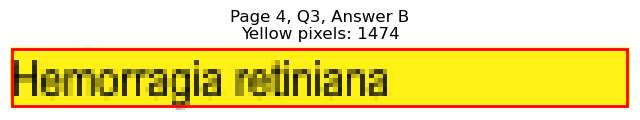

Page 4, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=413.8, y1=291.5
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 451
Page 4, Q3, C: Yellow percentage: 0.0%


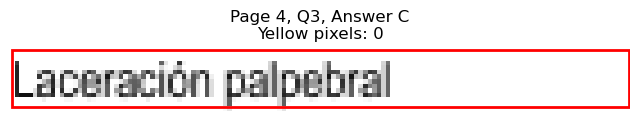

Page 4, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=418.9, y1=304.1
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 454
Page 4, Q3, D: Yellow percentage: 0.0%


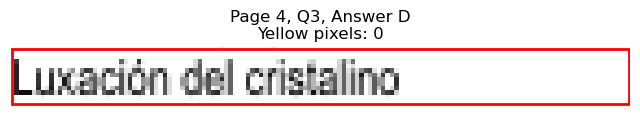


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=166.1, y1=341.9
Page 4, Q4, A: Yellow pixels: 1543
Page 4, Q4, A: Total non-white pixels: 1937
Page 4, Q4, A: Yellow percentage: 79.7%


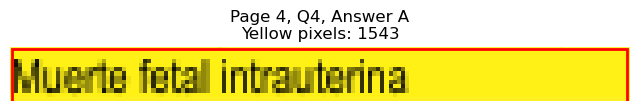

Page 4, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=92.9, y1=354.6
Page 4, Q4, B: Yellow pixels: 75
Page 4, Q4, B: Total non-white pixels: 190
Page 4, Q4, B: Yellow percentage: 39.5%


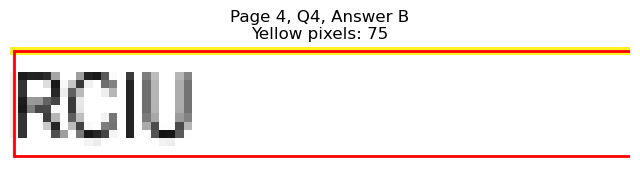

Page 4, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=395.2, y1=341.9
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 355
Page 4, Q4, C: Yellow percentage: 0.0%


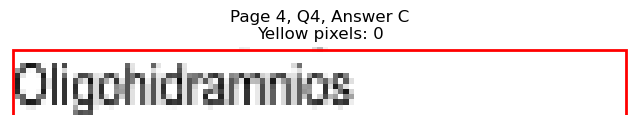

Page 4, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=398.7, y1=354.6
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 353
Page 4, Q4, D: Yellow percentage: 0.0%


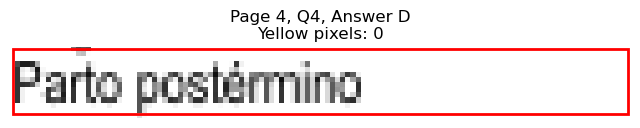


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=146.1, y1=405.0
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 513
Page 4, Q5, A: Yellow percentage: 0.0%


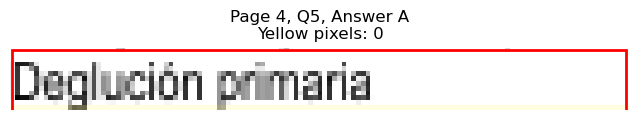

Page 4, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=172.1, y1=417.6
Page 4, Q5, B: Yellow pixels: 1596
Page 4, Q5, B: Total non-white pixels: 2170
Page 4, Q5, B: Yellow percentage: 73.5%


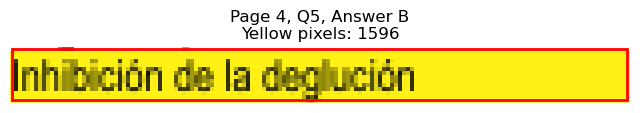

Page 4, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=417.8, y1=405.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 468
Page 4, Q5, C: Yellow percentage: 0.0%


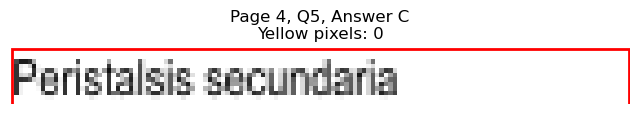

Page 4, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=416.8, y1=417.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 478
Page 4, Q5, D: Yellow percentage: 0.0%


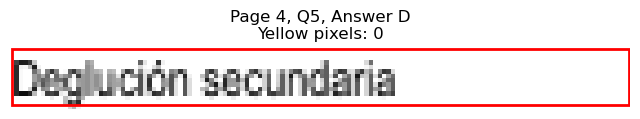


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=137.5, y1=480.7
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 369
Page 4, Q6, A: Yellow percentage: 0.0%


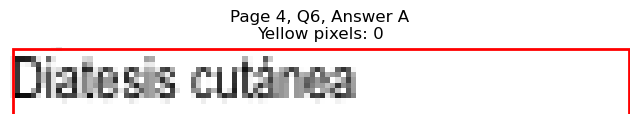

Page 4, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=127.0, y1=493.4
Page 4, Q6, B: Yellow pixels: 1062
Page 4, Q6, B: Total non-white pixels: 1526
Page 4, Q6, B: Yellow percentage: 69.6%


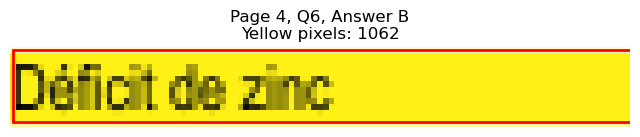

Page 4, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=394.3, y1=480.7
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 338
Page 4, Q6, C: Yellow percentage: 0.0%


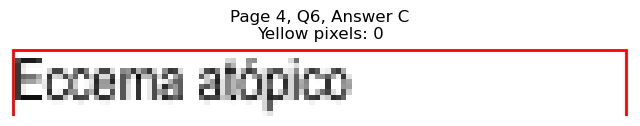

Page 4, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=416.8, y1=493.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 497
Page 4, Q6, D: Yellow percentage: 0.0%


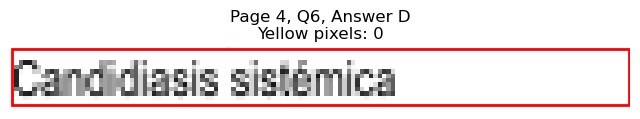


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=125.4, y1=569.2
Page 4, Q7, A: Yellow pixels: 108
Page 4, Q7, A: Total non-white pixels: 392
Page 4, Q7, A: Yellow percentage: 27.6%


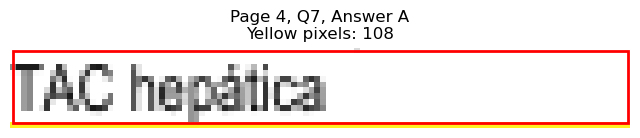

Page 4, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=137.1, y1=581.8
Page 4, Q7, B: Yellow pixels: 1279
Page 4, Q7, B: Total non-white pixels: 1560
Page 4, Q7, B: Yellow percentage: 82.0%


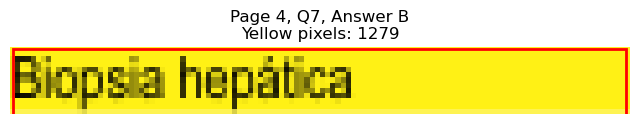

Page 4, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=421.9, y1=569.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 494
Page 4, Q7, C: Yellow percentage: 0.0%


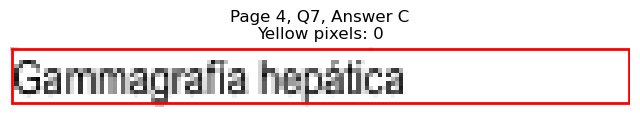

Page 4, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=405.3, y1=581.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 428
Page 4, Q7, D: Yellow percentage: 0.0%


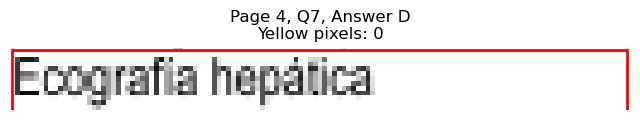


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=149.5, y1=644.9
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 397
Page 4, Q8, A: Yellow percentage: 0.0%


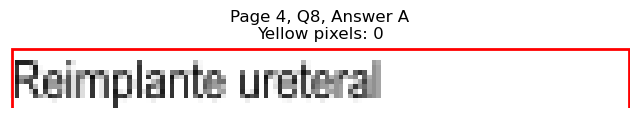

Page 4, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=119.9, y1=657.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 279
Page 4, Q8, B: Yellow percentage: 0.0%


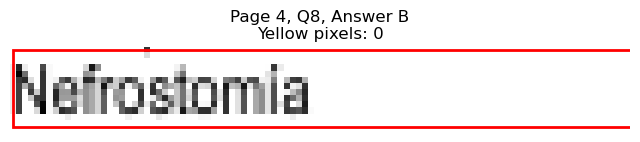

Page 4, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=418.9, y1=644.9
Page 4, Q8, C: Yellow pixels: 1499
Page 4, Q8, C: Total non-white pixels: 1846
Page 4, Q8, C: Yellow percentage: 81.2%


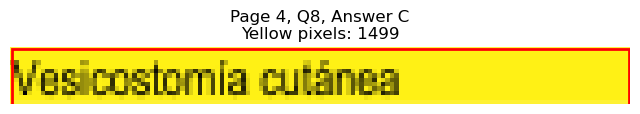

Page 4, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=404.2, y1=657.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 385
Page 4, Q8, D: Yellow percentage: 0.0%


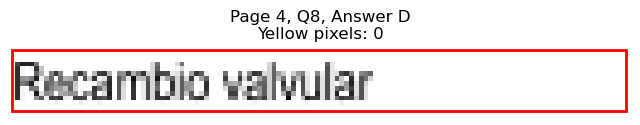


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=720.6, x1=114.5, y1=733.2
Page 4, Q9, A: Yellow pixels: 1063
Page 4, Q9, A: Total non-white pixels: 1358
Page 4, Q9, A: Yellow percentage: 78.3%


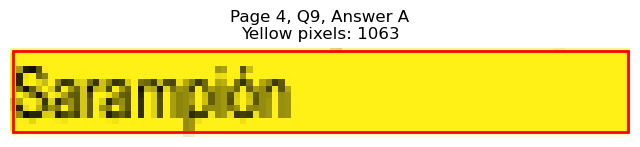

Page 4, Q9 - B: Detected box: x0=68.3, y0=733.2, x1=144.5, y1=745.8
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 513
Page 4, Q9, B: Yellow percentage: 0.0%


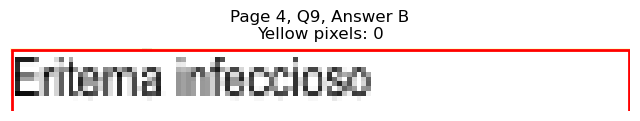

Page 4, Q9 - C: Detected box: x0=327.5, y0=720.6, x1=397.3, y1=733.2
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 342
Page 4, Q9, C: Yellow percentage: 0.0%


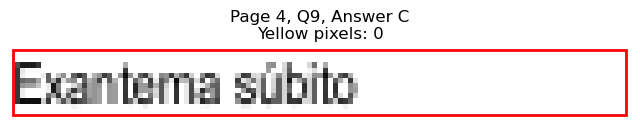

Page 4, Q9 - D: Detected box: x0=327.5, y0=733.2, x1=361.2, y1=745.8
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 196
Page 4, Q9, D: Yellow percentage: 0.0%


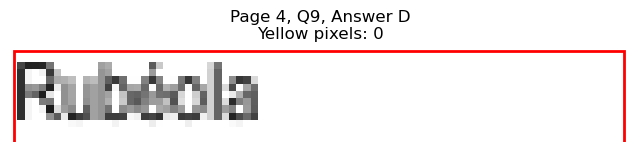


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=179.7, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 549
Page 5, Q1, A: Yellow percentage: 0.0%


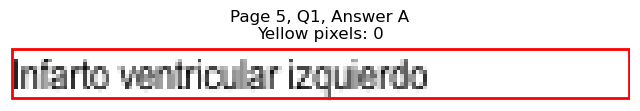

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=175.6, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 525
Page 5, Q1, B: Yellow percentage: 0.0%


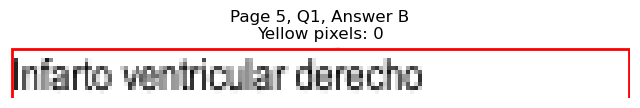

Page 5, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=432.9, y1=127.3
Page 5, Q1, C: Yellow pixels: 1479
Page 5, Q1, C: Total non-white pixels: 2184
Page 5, Q1, C: Yellow percentage: 67.7%


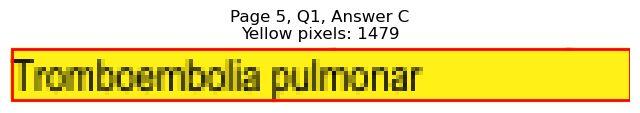

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=430.9, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 662
Page 5, Q1, D: Yellow percentage: 0.0%


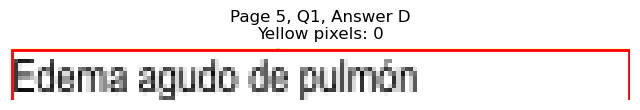


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=139.5, y1=203.0
Page 5, Q2, A: Yellow pixels: 1303
Page 5, Q2, A: Total non-white pixels: 1586
Page 5, Q2, A: Yellow percentage: 82.2%


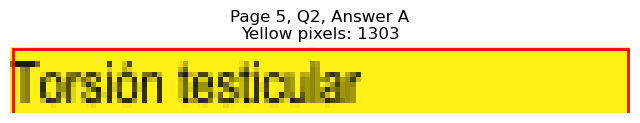

Page 5, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=140.7, y1=215.6
Page 5, Q2, B: Yellow pixels: 123
Page 5, Q2, B: Total non-white pixels: 484
Page 5, Q2, B: Yellow percentage: 25.4%


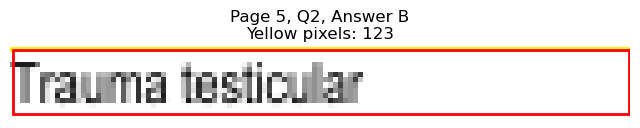

Page 5, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=421.9, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 520
Page 5, Q2, C: Yellow percentage: 0.0%


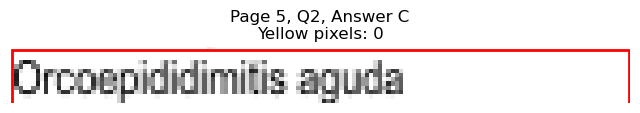

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=408.4, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 426
Page 5, Q2, D: Yellow percentage: 0.0%


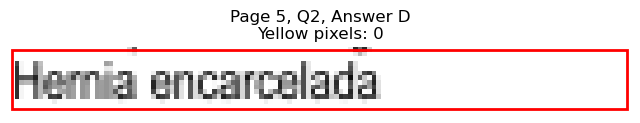


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=80.9, y1=253.5
Page 5, Q3, A: Yellow pixels: 63
Page 5, Q3, A: Total non-white pixels: 134
Page 5, Q3, A: Yellow percentage: 47.0%


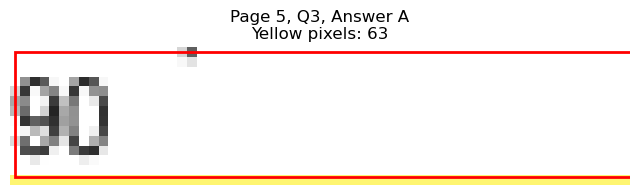

Page 5, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=80.9, y1=266.1
Page 5, Q3, B: Yellow pixels: 769
Page 5, Q3, B: Total non-white pixels: 882
Page 5, Q3, B: Yellow percentage: 87.2%


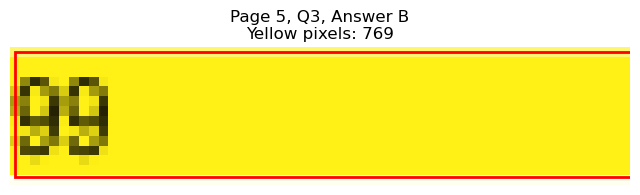

Page 5, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=340.1, y1=253.5
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 65
Page 5, Q3, C: Yellow percentage: 0.0%


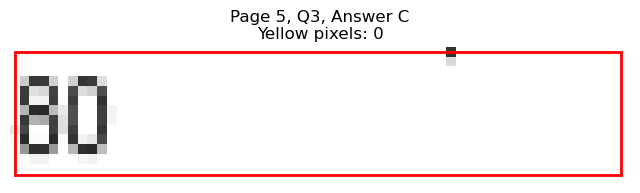

Page 5, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=340.1, y1=266.1
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 65
Page 5, Q3, D: Yellow percentage: 0.0%


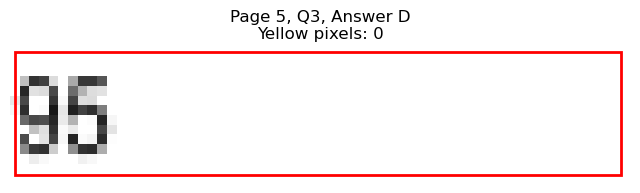


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=180.6, y1=329.3
Page 5, Q4, A: Yellow pixels: 1516
Page 5, Q4, A: Total non-white pixels: 2282
Page 5, Q4, A: Yellow percentage: 66.4%


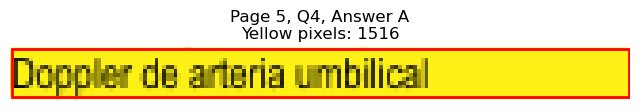

Page 5, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=133.0, y1=341.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 448
Page 5, Q4, B: Yellow percentage: 0.0%


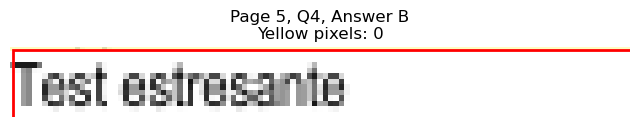

Page 5, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=404.8, y1=329.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 388
Page 5, Q4, C: Yellow percentage: 0.0%


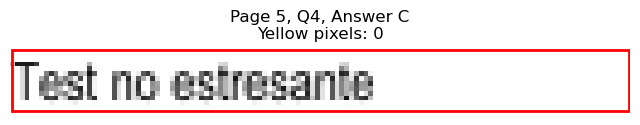

Page 5, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=405.8, y1=341.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 407
Page 5, Q4, D: Yellow percentage: 0.0%


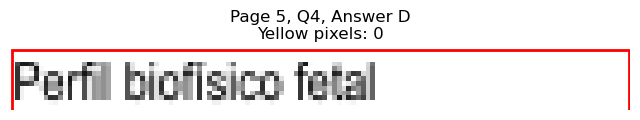


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=125.4, y1=379.8
Page 5, Q5, A: Yellow pixels: 1162
Page 5, Q5, A: Total non-white pixels: 1404
Page 5, Q5, A: Yellow percentage: 82.8%


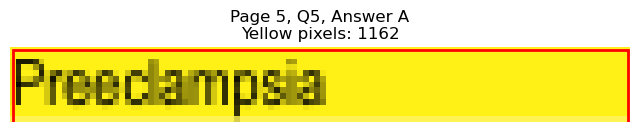

Page 5, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=138.0, y1=392.4
Page 5, Q5, B: Yellow pixels: 121
Page 5, Q5, B: Total non-white pixels: 448
Page 5, Q5, B: Yellow percentage: 27.0%


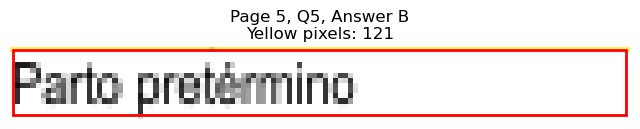

Page 5, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=422.8, y1=379.8
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 497
Page 5, Q5, C: Yellow percentage: 0.0%


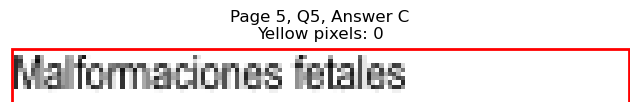

Page 5, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=428.8, y1=392.4
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 529
Page 5, Q5, D: Yellow percentage: 0.0%


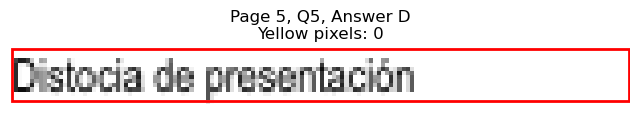


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=115.0, y1=455.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 243
Page 5, Q6, A: Yellow percentage: 0.0%


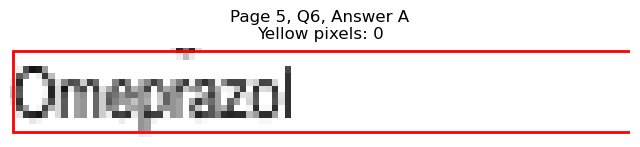

Page 5, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=171.1, y1=468.1
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 526
Page 5, Q6, B: Yellow percentage: 0.0%


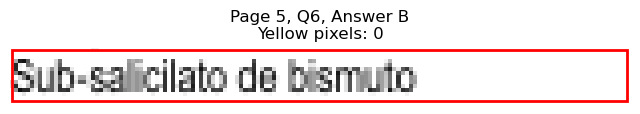

Page 5, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=381.7, y1=455.5
Page 5, Q6, C: Yellow pixels: 1146
Page 5, Q6, C: Total non-white pixels: 1470
Page 5, Q6, C: Yellow percentage: 78.0%


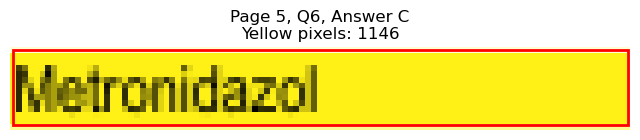

Page 5, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=375.7, y1=468.1
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 253
Page 5, Q6, D: Yellow percentage: 0.0%


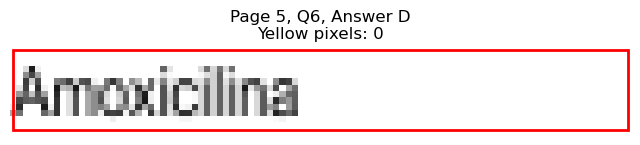


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=109.0, y1=543.8
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 199
Page 5, Q7, A: Yellow percentage: 0.0%


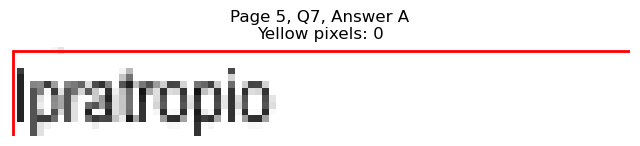

Page 5, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=115.9, y1=556.4
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 248
Page 5, Q7, B: Yellow percentage: 0.0%


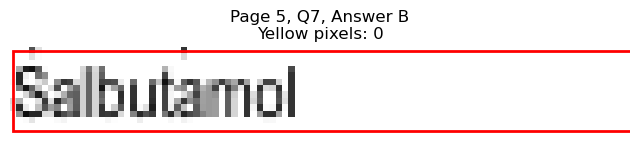

Page 5, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=375.2, y1=543.8
Page 5, Q7, C: Yellow pixels: 1093
Page 5, Q7, C: Total non-white pixels: 1287
Page 5, Q7, C: Yellow percentage: 84.9%


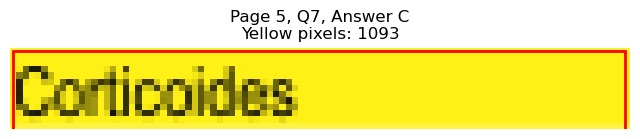

Page 5, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=395.7, y1=556.4
Page 5, Q7, D: Yellow pixels: 119
Page 5, Q7, D: Total non-white pixels: 485
Page 5, Q7, D: Yellow percentage: 24.5%


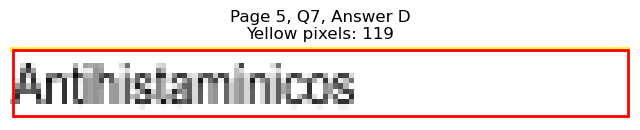


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=189.6, y1=619.6
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 600
Page 5, Q8, A: Yellow percentage: 0.0%


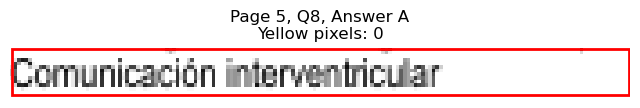

Page 5, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=211.7, y1=632.3
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 679
Page 5, Q8, B: Yellow percentage: 0.0%


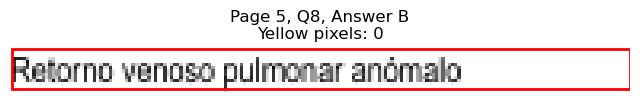

Page 5, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=468.6, y1=619.6
Page 5, Q8, C: Yellow pixels: 1947
Page 5, Q8, C: Total non-white pixels: 2688
Page 5, Q8, C: Yellow percentage: 72.4%


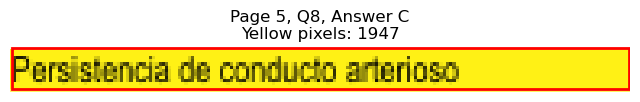

Page 5, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=441.9, y1=632.3
Page 5, Q8, D: Yellow pixels: 165
Page 5, Q8, D: Total non-white pixels: 723
Page 5, Q8, D: Yellow percentage: 22.8%


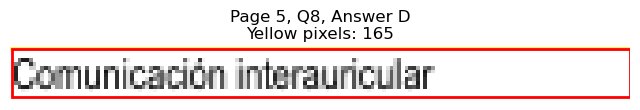


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=122.4, y1=708.0
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 281
Page 5, Q9, A: Yellow percentage: 0.0%


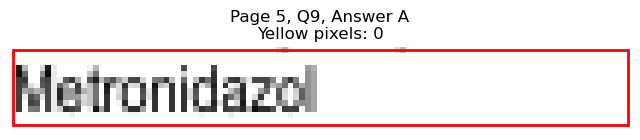

Page 5, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=112.5, y1=720.6
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 231
Page 5, Q9, B: Yellow percentage: 0.0%


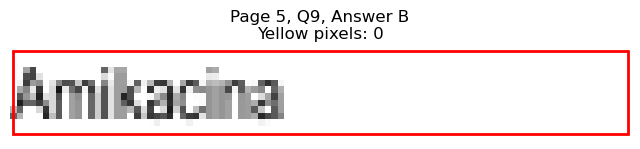

Page 5, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=376.1, y1=708.0
Page 5, Q9, C: Yellow pixels: 1099
Page 5, Q9, C: Total non-white pixels: 1300
Page 5, Q9, C: Yellow percentage: 84.5%


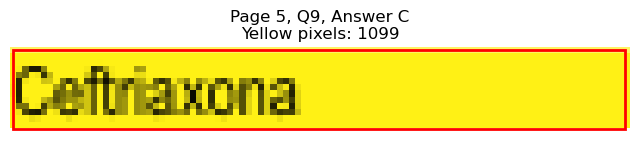

Page 5, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=384.7, y1=720.6
Page 5, Q9, D: Yellow pixels: 108
Page 5, Q9, D: Total non-white pixels: 424
Page 5, Q9, D: Yellow percentage: 25.5%


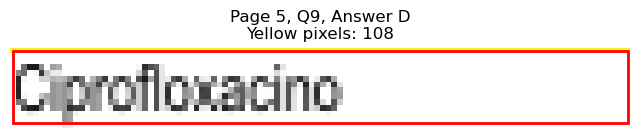


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=94.8, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 123
Page 6, Q1, A: Yellow percentage: 0.0%


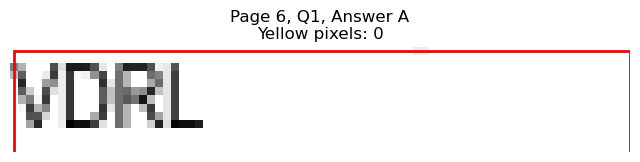

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=96.9, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 137
Page 6, Q1, B: Yellow percentage: 0.0%


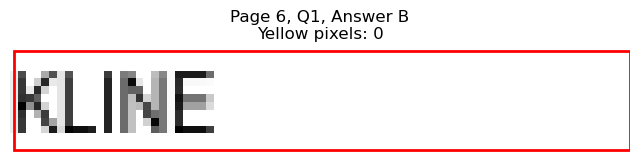

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=368.1, y1=114.7
Page 6, Q1, C: Yellow pixels: 1048
Page 6, Q1, C: Total non-white pixels: 1196
Page 6, Q1, C: Yellow percentage: 87.6%


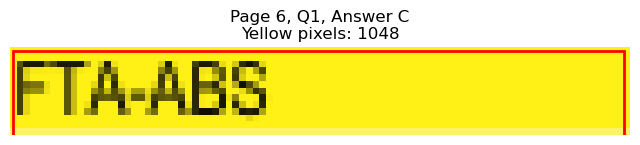

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=349.1, y1=127.3
Page 6, Q1, D: Yellow pixels: 73
Page 6, Q1, D: Total non-white pixels: 183
Page 6, Q1, D: Yellow percentage: 39.9%


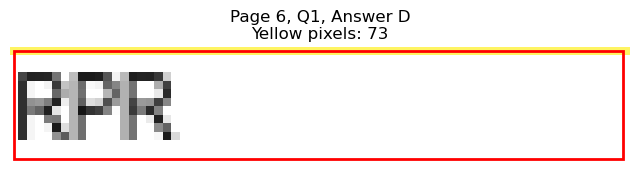


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=153.6, y1=203.0
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 406
Page 6, Q2, A: Yellow percentage: 0.0%


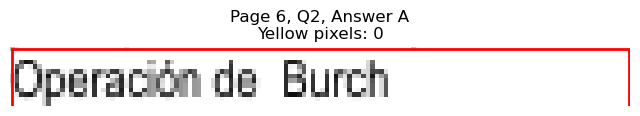

Page 6, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=134.1, y1=215.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 334
Page 6, Q2, B: Yellow percentage: 0.0%


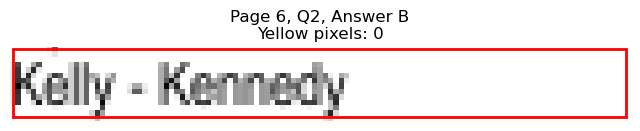

Page 6, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=413.3, y1=203.0
Page 6, Q2, C: Yellow pixels: 1468
Page 6, Q2, C: Total non-white pixels: 1781
Page 6, Q2, C: Yellow percentage: 82.4%


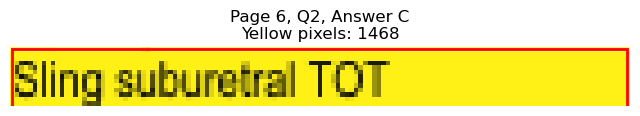

Page 6, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=433.4, y1=215.6
Page 6, Q2, D: Yellow pixels: 153
Page 6, Q2, D: Total non-white pixels: 727
Page 6, Q2, D: Yellow percentage: 21.0%


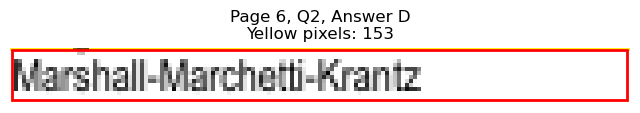


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=103.5, y1=253.5
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 200
Page 6, Q3, A: Yellow percentage: 0.0%


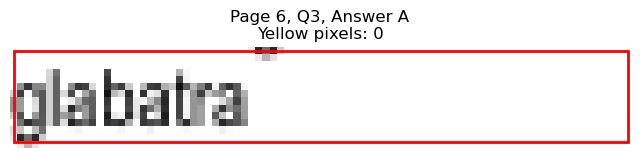

Page 6, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=94.9, y1=266.1
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 130
Page 6, Q3, B: Yellow percentage: 0.0%


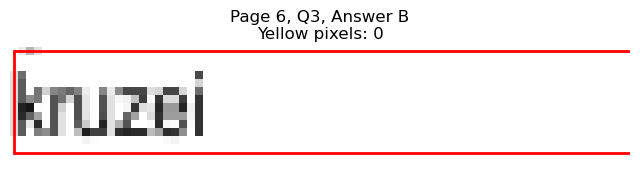

Page 6, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=363.2, y1=253.5
Page 6, Q3, C: Yellow pixels: 1001
Page 6, Q3, C: Total non-white pixels: 1218
Page 6, Q3, C: Yellow percentage: 82.2%


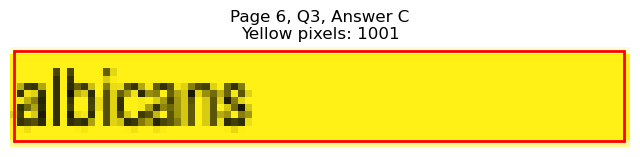

Page 6, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=365.7, y1=266.1
Page 6, Q3, D: Yellow pixels: 89
Page 6, Q3, D: Total non-white pixels: 302
Page 6, Q3, D: Yellow percentage: 29.5%


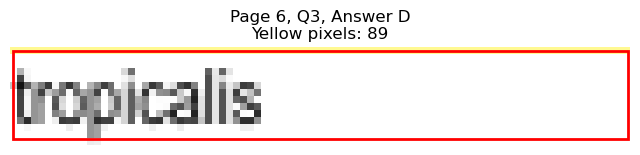


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=118.5, y1=316.7
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 235
Page 6, Q4, A: Yellow percentage: 0.0%


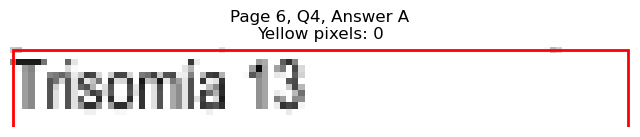

Page 6, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=126.5, y1=329.3
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 289
Page 6, Q4, B: Yellow percentage: 0.0%


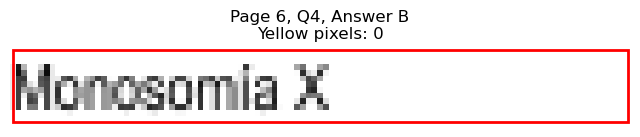

Page 6, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=377.7, y1=316.7
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 334
Page 6, Q4, C: Yellow percentage: 0.0%


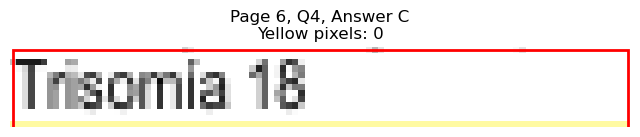

Page 6, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=377.8, y1=329.3
Page 6, Q4, D: Yellow pixels: 1040
Page 6, Q4, D: Total non-white pixels: 1414
Page 6, Q4, D: Yellow percentage: 73.6%


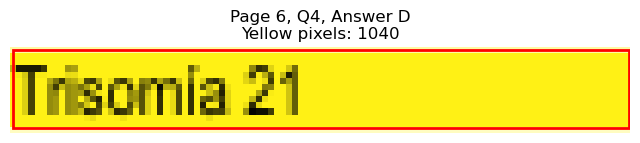


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=245.4, y1=392.4
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 889
Page 6, Q5, A: Yellow percentage: 0.0%


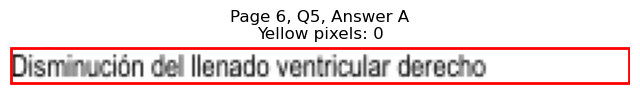

Page 6, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=205.2, y1=405.0
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 679
Page 6, Q5, B: Yellow percentage: 0.0%


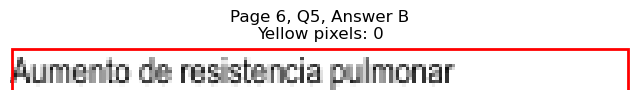

Page 6, Q5 - C: Detected box: x0=68.8, y0=404.9, x1=288.9, y1=417.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 1097
Page 6, Q5, C: Yellow percentage: 0.0%


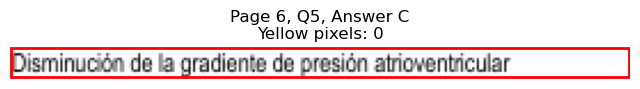

Page 6, Q5 - D: Detected box: x0=68.8, y0=417.6, x1=249.9, y1=430.3
Page 6, Q5, D: Yellow pixels: 2059
Page 6, Q5, D: Total non-white pixels: 3248
Page 6, Q5, D: Yellow percentage: 63.4%


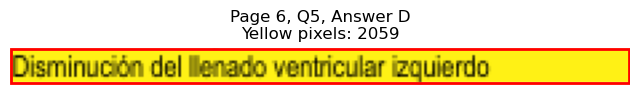


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=140.5, y1=493.4
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 373
Page 6, Q6, A: Yellow percentage: 0.0%


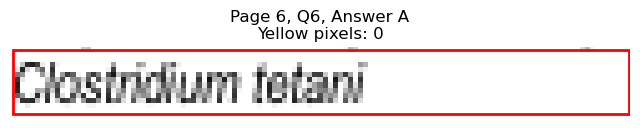

Page 6, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=178.1, y1=506.0
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 542
Page 6, Q6, B: Yellow percentage: 0.0%


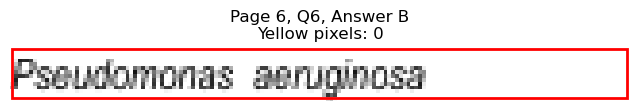

Page 6, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=420.8, y1=493.4
Page 6, Q6, C: Yellow pixels: 144
Page 6, Q6, C: Total non-white pixels: 634
Page 6, Q6, C: Yellow percentage: 22.7%


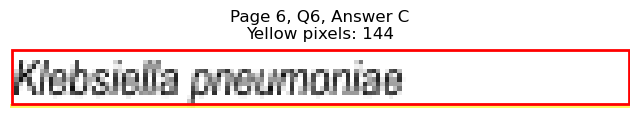

Page 6, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=420.8, y1=506.0
Page 6, Q6, D: Yellow pixels: 1501
Page 6, Q6, D: Total non-white pixels: 1873
Page 6, Q6, D: Yellow percentage: 80.1%


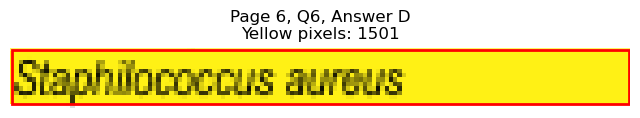


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=164.1, y1=569.2
Page 6, Q7, A: Yellow pixels: 1542
Page 6, Q7, A: Total non-white pixels: 2058
Page 6, Q7, A: Yellow percentage: 74.9%


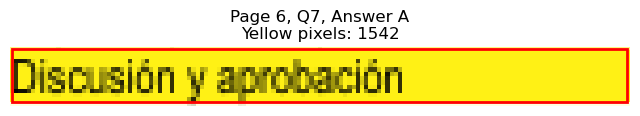

Page 6, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=120.5, y1=581.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 341
Page 6, Q7, B: Yellow percentage: 0.0%


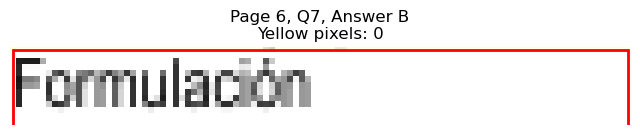

Page 6, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=377.2, y1=569.2
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 278
Page 6, Q7, C: Yellow percentage: 0.0%


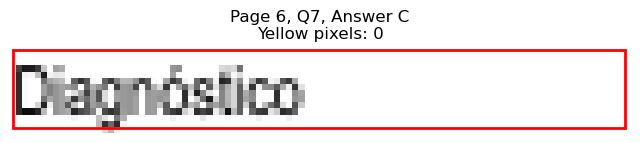

Page 6, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=421.9, y1=581.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 472
Page 6, Q7, D: Yellow percentage: 0.0%


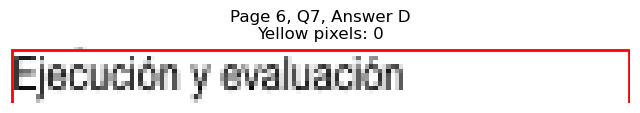


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=175.6, y1=644.9
Page 6, Q8, A: Yellow pixels: 1629
Page 6, Q8, A: Total non-white pixels: 2054
Page 6, Q8, A: Yellow percentage: 79.3%


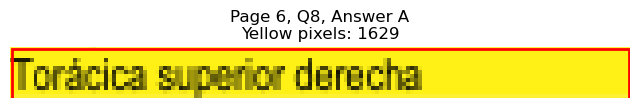

Page 6, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=179.7, y1=657.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 563
Page 6, Q8, B: Yellow percentage: 0.0%


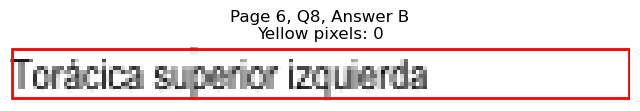

Page 6, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=423.8, y1=644.9
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 500
Page 6, Q8, C: Yellow percentage: 0.0%


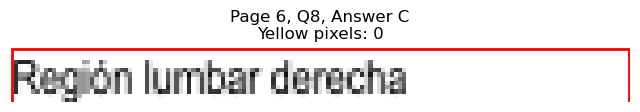

Page 6, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=427.9, y1=657.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 541
Page 6, Q8, D: Yellow percentage: 0.0%


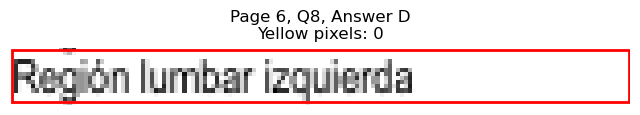


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=164.5, y1=708.0
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 478
Page 6, Q9, A: Yellow percentage: 0.0%


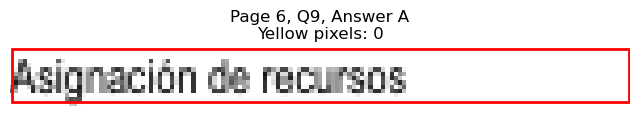

Page 6, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=115.0, y1=720.6
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 237
Page 6, Q9, B: Yellow percentage: 0.0%


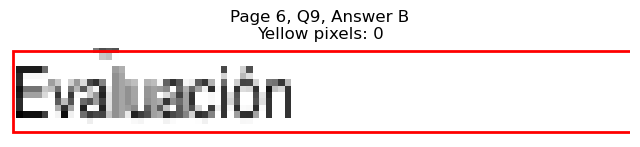

Page 6, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=419.3, y1=708.0
Page 6, Q9, C: Yellow pixels: 143
Page 6, Q9, C: Total non-white pixels: 759
Page 6, Q9, C: Yellow percentage: 18.8%


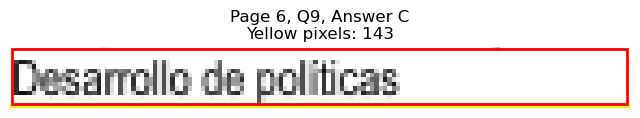

Page 6, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=359.7, y1=720.6
Page 6, Q9, D: Yellow pixels: 965
Page 6, Q9, D: Total non-white pixels: 1162
Page 6, Q9, D: Yellow percentage: 83.0%


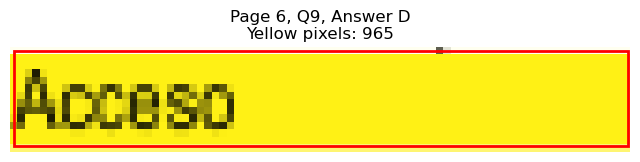


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=197.2, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 666
Page 7, Q1, A: Yellow percentage: 0.0%


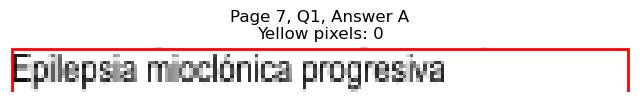

Page 7, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=188.7, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 591
Page 7, Q1, B: Yellow percentage: 0.0%


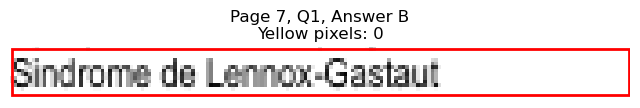

Page 7, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=404.2, y1=114.7
Page 7, Q1, C: Yellow pixels: 1385
Page 7, Q1, C: Total non-white pixels: 1664
Page 7, Q1, C: Yellow percentage: 83.2%


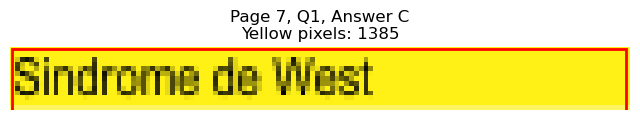

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=447.9, y1=127.3
Page 7, Q1, D: Yellow pixels: 171
Page 7, Q1, D: Total non-white pixels: 738
Page 7, Q1, D: Yellow percentage: 23.2%


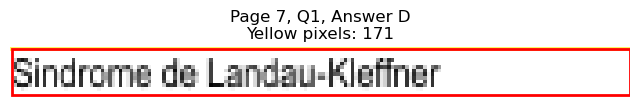


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=150.0, y1=177.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 551
Page 7, Q2, A: Yellow percentage: 0.0%


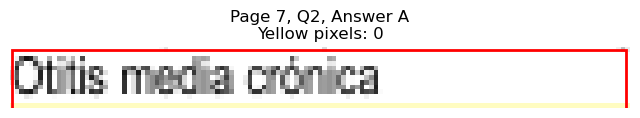

Page 7, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=124.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 1062
Page 7, Q2, B: Total non-white pixels: 1484
Page 7, Q2, B: Yellow percentage: 71.6%


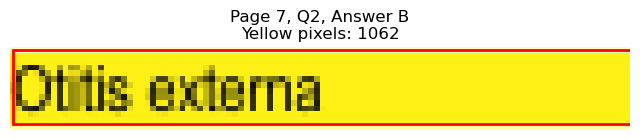

Page 7, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=411.3, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 423
Page 7, Q2, C: Yellow percentage: 0.0%


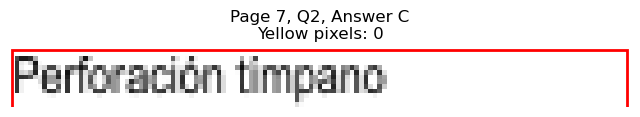

Page 7, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=405.3, y1=190.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 405
Page 7, Q2, D: Yellow percentage: 0.0%


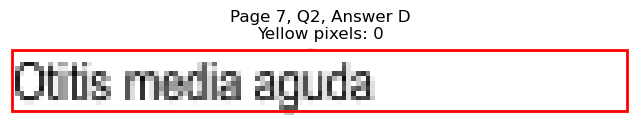


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=192.7, y1=240.9
Page 7, Q3, A: Yellow pixels: 1808
Page 7, Q3, A: Total non-white pixels: 2275
Page 7, Q3, A: Yellow percentage: 79.5%


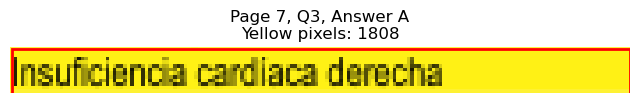

Page 7, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=196.2, y1=253.5
Page 7, Q3, B: Yellow pixels: 179
Page 7, Q3, B: Total non-white pixels: 817
Page 7, Q3, B: Yellow percentage: 21.9%


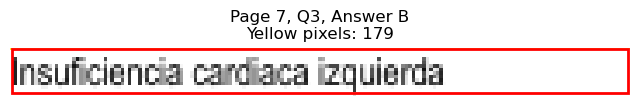

Page 7, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=398.8, y1=240.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 358
Page 7, Q3, C: Yellow percentage: 0.0%


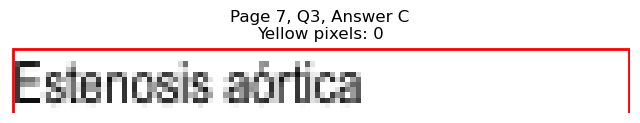

Page 7, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=402.3, y1=253.5
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 385
Page 7, Q3, D: Yellow percentage: 0.0%


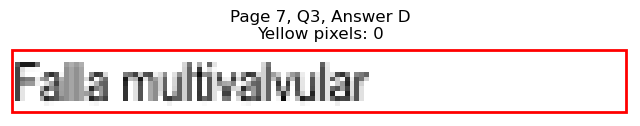


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=175.1, y1=304.1
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 531
Page 7, Q4, A: Yellow percentage: 0.0%


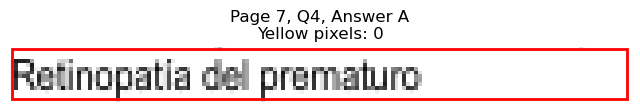

Page 7, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=144.5, y1=316.7
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 405
Page 7, Q4, B: Yellow percentage: 0.0%


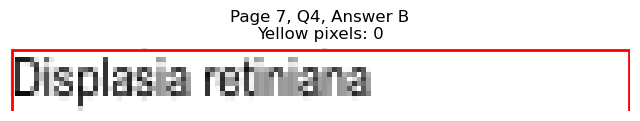

Page 7, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=385.3, y1=304.1
Page 7, Q4, C: Yellow pixels: 109
Page 7, Q4, C: Total non-white pixels: 411
Page 7, Q4, C: Yellow percentage: 26.5%


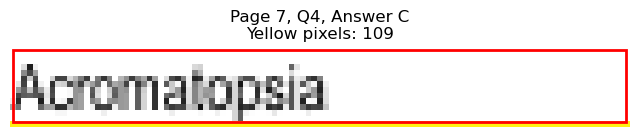

Page 7, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=390.2, y1=316.7
Page 7, Q4, D: Yellow pixels: 1249
Page 7, Q4, D: Total non-white pixels: 1482
Page 7, Q4, D: Yellow percentage: 84.3%


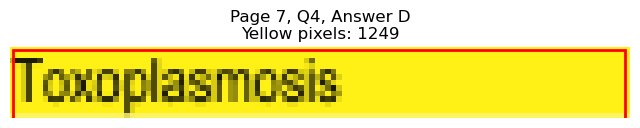


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=102.9, y1=392.4
Page 7, Q5, A: Yellow pixels: 877
Page 7, Q5, A: Total non-white pixels: 1190
Page 7, Q5, A: Yellow percentage: 73.7%


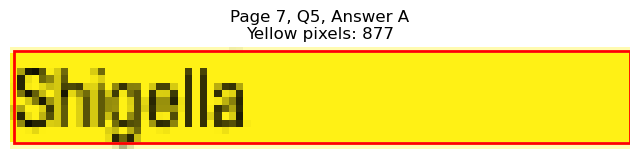

Page 7, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=130.9, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 413
Page 7, Q5, B: Yellow percentage: 0.0%


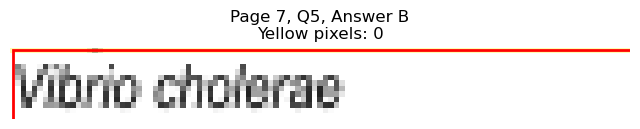

Page 7, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=390.8, y1=392.4
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 337
Page 7, Q5, C: Yellow percentage: 0.0%


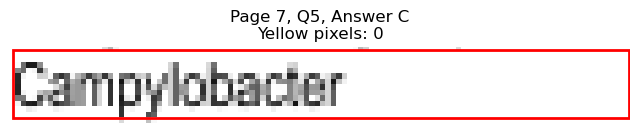

Page 7, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=392.7, y1=405.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 334
Page 7, Q5, D: Yellow percentage: 0.0%


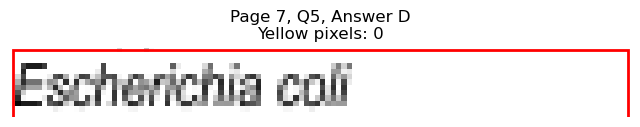


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=137.1, y1=455.5
Page 7, Q6, A: Yellow pixels: 1284
Page 7, Q6, A: Total non-white pixels: 1680
Page 7, Q6, A: Yellow percentage: 76.4%


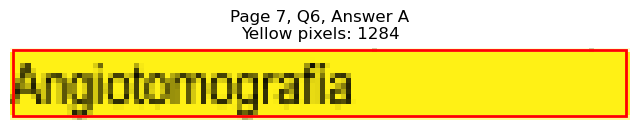

Page 7, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=109.5, y1=468.1
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 205
Page 7, Q6, B: Yellow percentage: 0.0%


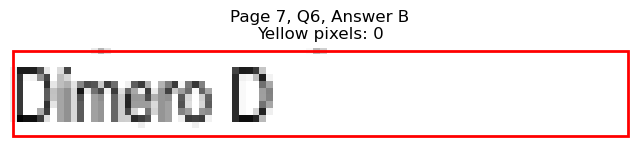

Page 7, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=393.3, y1=455.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 351
Page 7, Q6, C: Yellow percentage: 0.0%


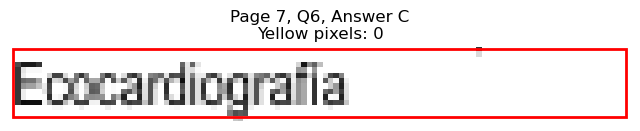

Page 7, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=401.2, y1=468.1
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 396
Page 7, Q6, D: Yellow percentage: 0.0%


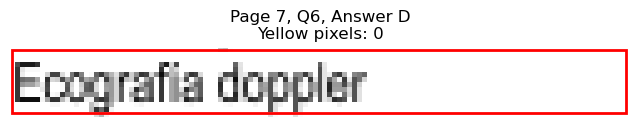


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=102.9, y1=531.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 158
Page 7, Q7, A: Yellow percentage: 0.0%


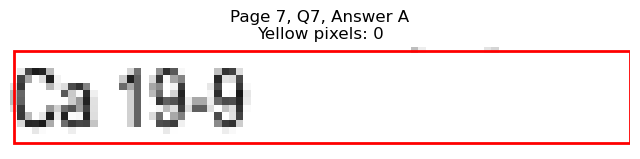

Page 7, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=88.3, y1=543.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 85
Page 7, Q7, B: Yellow percentage: 0.0%


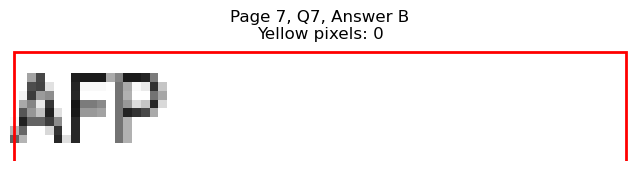

Page 7, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=359.7, y1=531.2
Page 7, Q7, C: Yellow pixels: 964
Page 7, Q7, C: Total non-white pixels: 1162
Page 7, Q7, C: Yellow percentage: 83.0%


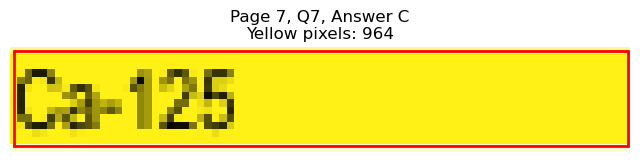

Page 7, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=353.1, y1=543.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 206
Page 7, Q7, D: Yellow percentage: 0.0%


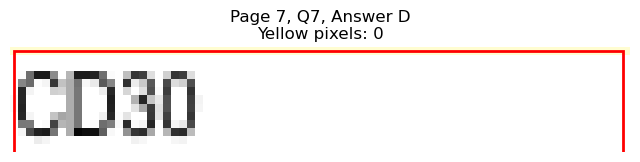


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=65.2, y1=594.4
Page 7, Q8, A: Yellow pixels: 660
Page 7, Q8, A: Total non-white pixels: 840
Page 7, Q8, A: Yellow percentage: 78.6%


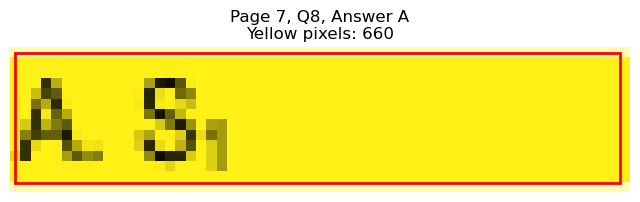

Page 7, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=65.2, y1=607.0
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 155
Page 7, Q8, B: Yellow percentage: 0.0%


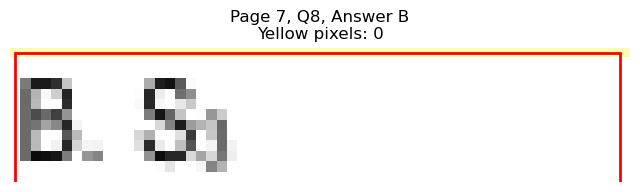

Page 7, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=324.4, y1=594.4
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 86
Page 7, Q8, C: Yellow percentage: 0.0%


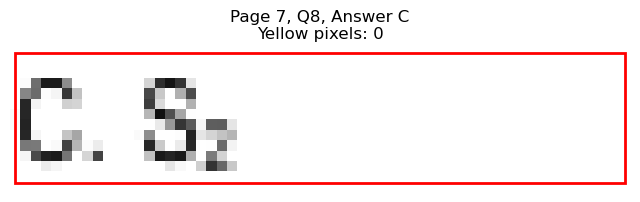

Page 7, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=324.4, y1=607.0
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 89
Page 7, Q8, D: Yellow percentage: 0.0%


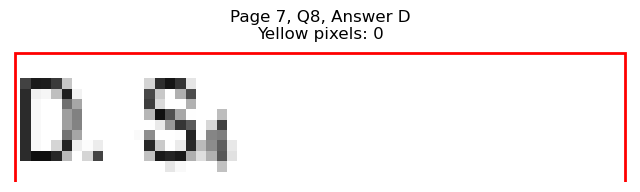


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=144.5, y1=670.1
Page 7, Q9, A: Yellow pixels: 1379
Page 7, Q9, A: Total non-white pixels: 1778
Page 7, Q9, A: Yellow percentage: 77.6%


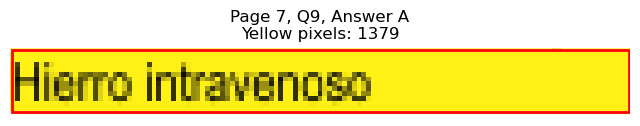

Page 7, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=147.0, y1=682.7
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 513
Page 7, Q9, B: Yellow percentage: 0.0%


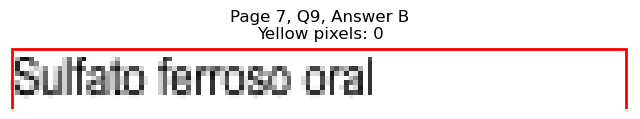

Page 7, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=411.3, y1=670.1
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 431
Page 7, Q9, C: Yellow percentage: 0.0%


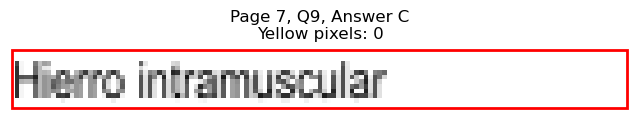

Page 7, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=439.4, y1=682.7
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 580
Page 7, Q9, D: Yellow percentage: 0.0%


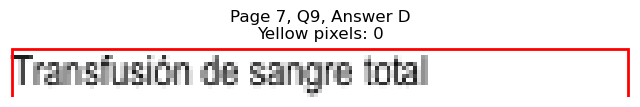


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=179.7, y1=758.4
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 557
Page 7, Q10, A: Yellow percentage: 0.0%


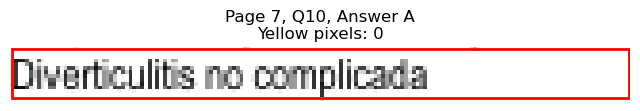

Page 7, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=167.1, y1=771.2
Page 7, Q10, B: Yellow pixels: 1565
Page 7, Q10, B: Total non-white pixels: 2100
Page 7, Q10, B: Yellow percentage: 74.5%


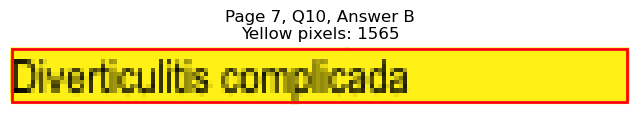

Page 7, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=403.7, y1=758.4
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 389
Page 7, Q10, C: Yellow percentage: 0.0%


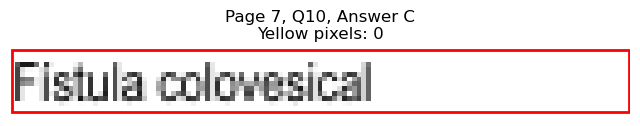

Page 7, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=402.3, y1=771.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 405
Page 7, Q10, D: Yellow percentage: 0.0%


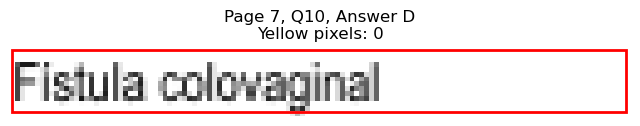


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=127.9, y1=127.3
Page 8, Q1, A: Yellow pixels: 110
Page 8, Q1, A: Total non-white pixels: 404
Page 8, Q1, A: Yellow percentage: 27.2%


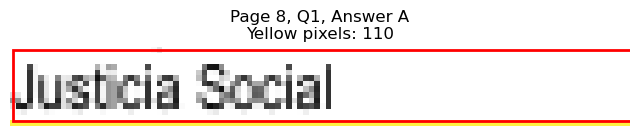

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=195.7, y1=139.9
Page 8, Q1, B: Yellow pixels: 1841
Page 8, Q1, B: Total non-white pixels: 2314
Page 8, Q1, B: Yellow percentage: 79.6%


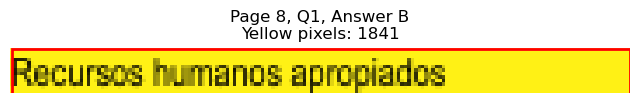

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=424.4, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 487
Page 8, Q1, C: Yellow percentage: 0.0%


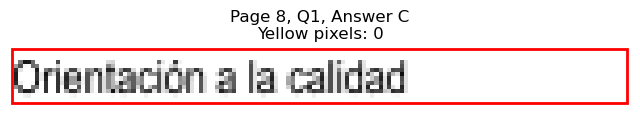

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=489.6, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 836
Page 8, Q1, D: Yellow percentage: 0.0%


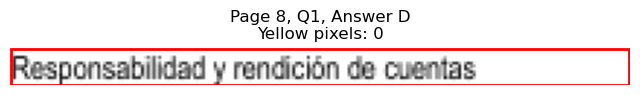


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=159.0, y1=203.0
Page 8, Q2, A: Yellow pixels: 1506
Page 8, Q2, A: Total non-white pixels: 1846
Page 8, Q2, A: Yellow percentage: 81.6%


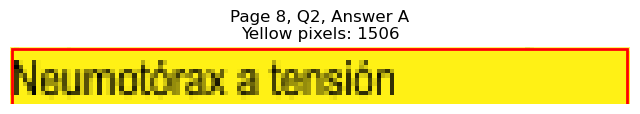

Page 8, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=115.0, y1=215.6
Page 8, Q2, B: Yellow pixels: 97
Page 8, Q2, B: Total non-white pixels: 332
Page 8, Q2, B: Yellow percentage: 29.2%


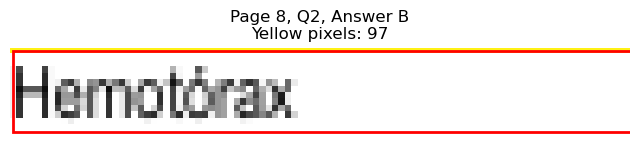

Page 8, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=410.8, y1=203.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 406
Page 8, Q2, C: Yellow percentage: 0.0%


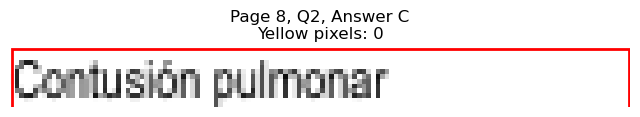

Page 8, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=407.8, y1=215.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 418
Page 8, Q2, D: Yellow percentage: 0.0%


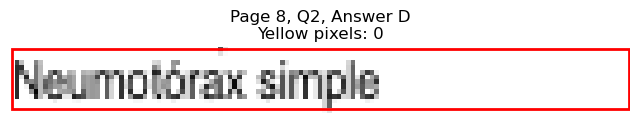


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=175.6, y1=291.5
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 552
Page 8, Q3, A: Yellow percentage: 0.0%


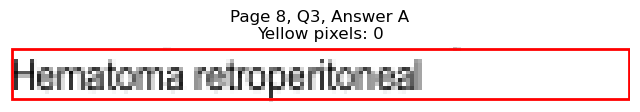

Page 8, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=166.1, y1=304.1
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 471
Page 8, Q3, B: Yellow percentage: 0.0%


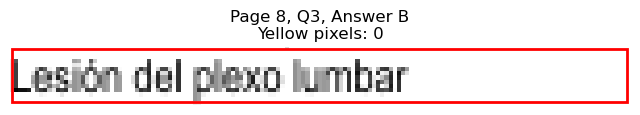

Page 8, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=390.2, y1=291.5
Page 8, Q3, C: Yellow pixels: 114
Page 8, Q3, C: Total non-white pixels: 425
Page 8, Q3, C: Yellow percentage: 26.8%


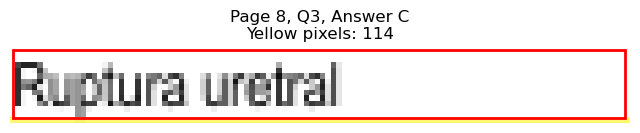

Page 8, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=451.9, y1=304.1
Page 8, Q3, D: Yellow pixels: 1774
Page 8, Q3, D: Total non-white pixels: 2450
Page 8, Q3, D: Yellow percentage: 72.4%


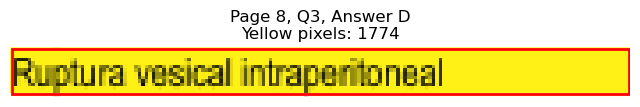


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=116.9, y1=367.2
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 244
Page 8, Q4, A: Yellow percentage: 0.0%


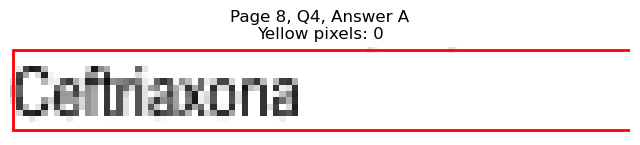

Page 8, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=141.5, y1=379.8
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 376
Page 8, Q4, B: Yellow percentage: 0.0%


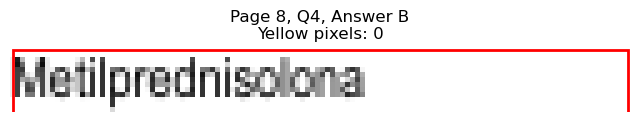

Page 8, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=396.3, y1=367.2
Page 8, Q4, C: Yellow pixels: 1304
Page 8, Q4, C: Total non-white pixels: 1680
Page 8, Q4, C: Yellow percentage: 77.6%


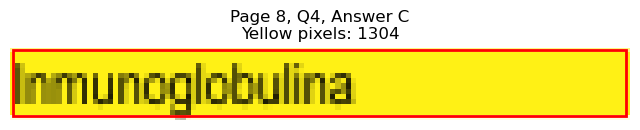

Page 8, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=377.7, y1=379.8
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 380
Page 8, Q4, D: Yellow percentage: 0.0%


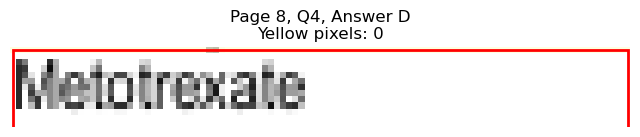


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=430.2, x1=110.9, y1=442.9
Page 8, Q5, A: Yellow pixels: 1042
Page 8, Q5, A: Total non-white pixels: 1209
Page 8, Q5, A: Yellow percentage: 86.2%


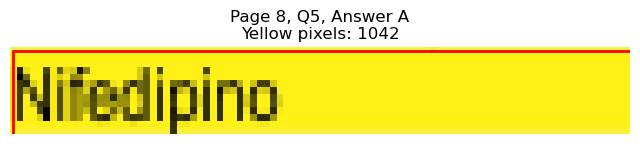

Page 8, Q5 - B: Detected box: x0=68.3, y0=442.8, x1=109.9, y1=455.5
Page 8, Q5, B: Yellow pixels: 91
Page 8, Q5, B: Total non-white pixels: 314
Page 8, Q5, B: Yellow percentage: 29.0%


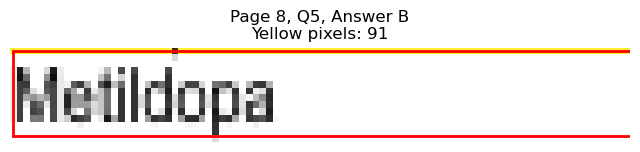

Page 8, Q5 - C: Detected box: x0=327.5, y0=430.2, x1=366.2, y1=442.9
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 213
Page 8, Q5, C: Yellow percentage: 0.0%


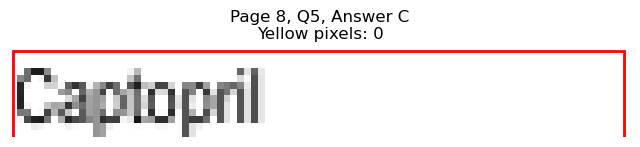

Page 8, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=365.2, y1=455.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 184
Page 8, Q5, D: Yellow percentage: 0.0%


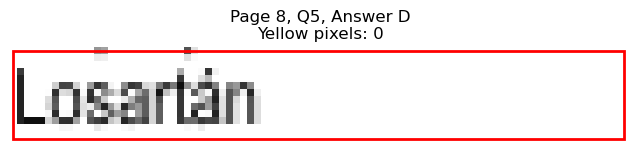


Page 8, Q5 - Selected Answer: A (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=171.6, y1=531.2
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 506
Page 8, Q6, A: Yellow percentage: 0.0%


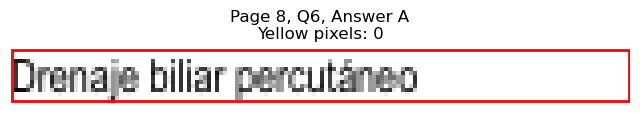

Page 8, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=125.5, y1=543.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 288
Page 8, Q6, B: Yellow percentage: 0.0%


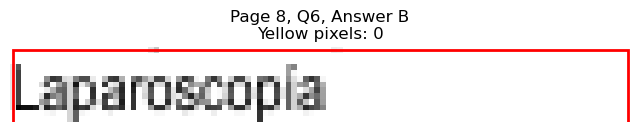

Page 8, Q6 - C: Detected box: x0=327.5, y0=518.6, x1=355.1, y1=531.2
Page 8, Q6, C: Yellow pixels: 916
Page 8, Q6, C: Total non-white pixels: 1106
Page 8, Q6, C: Yellow percentage: 82.8%


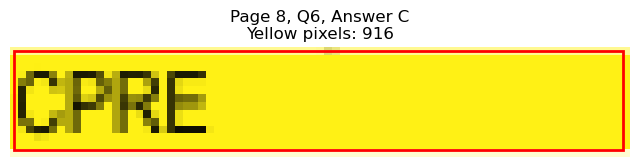

Page 8, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=380.7, y1=543.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 360
Page 8, Q6, D: Yellow percentage: 0.0%


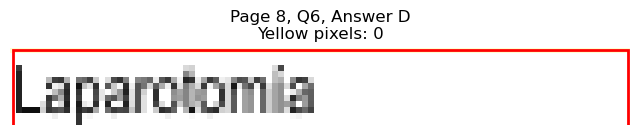


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=116.9, y1=594.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 235
Page 8, Q7, A: Yellow percentage: 0.0%


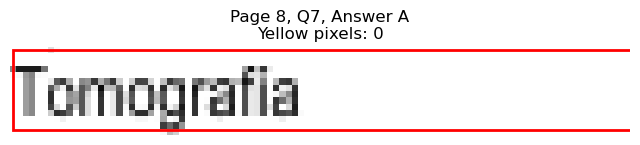

Page 8, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=168.1, y1=607.0
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 489
Page 8, Q7, B: Yellow percentage: 0.0%


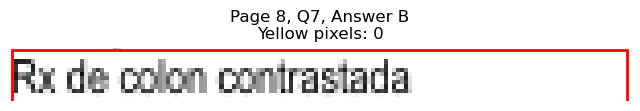

Page 8, Q7 - C: Detected box: x0=327.5, y0=581.7, x1=385.3, y1=594.4
Page 8, Q7, C: Yellow pixels: 1077
Page 8, Q7, C: Total non-white pixels: 1526
Page 8, Q7, C: Yellow percentage: 70.6%


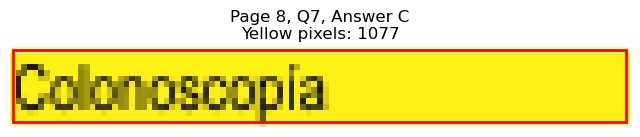

Page 8, Q7 - D: Detected box: x0=327.5, y0=594.3, x1=416.3, y1=607.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 608
Page 8, Q7, D: Yellow percentage: 0.0%


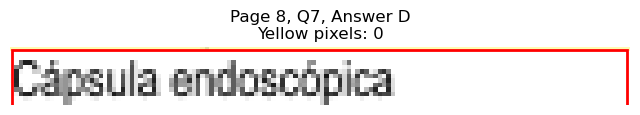


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=93.9, y1=657.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 125
Page 8, Q8, A: Yellow percentage: 0.0%


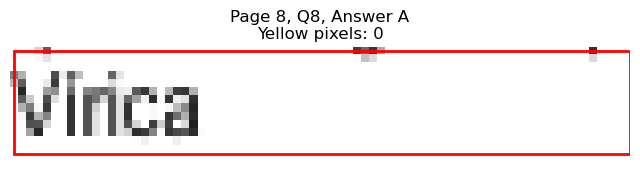

Page 8, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=123.5, y1=670.1
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 274
Page 8, Q8, B: Yellow percentage: 0.0%


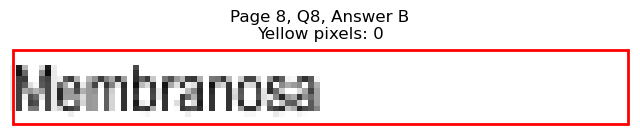

Page 8, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=373.1, y1=657.5
Page 8, Q8, C: Yellow pixels: 1087
Page 8, Q8, C: Total non-white pixels: 1358
Page 8, Q8, C: Yellow percentage: 80.0%


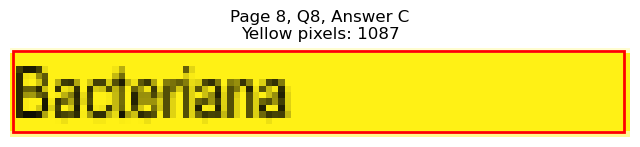

Page 8, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=362.7, y1=670.1
Page 8, Q8, D: Yellow pixels: 86
Page 8, Q8, D: Total non-white pixels: 266
Page 8, Q8, D: Yellow percentage: 32.3%


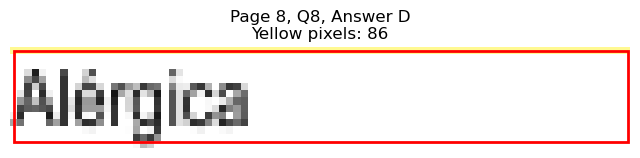


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=733.2, x1=168.6, y1=745.8
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 501
Page 8, Q9, A: Yellow percentage: 0.0%


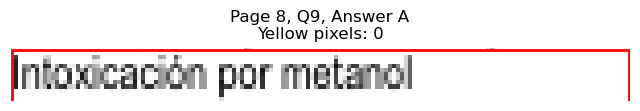

Page 8, Q9 - B: Detected box: x0=68.3, y0=745.8, x1=174.1, y1=758.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 513
Page 8, Q9, B: Yellow percentage: 0.0%


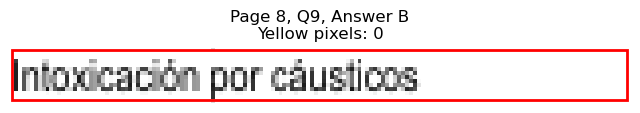

Page 8, Q9 - C: Detected box: x0=327.5, y0=733.2, x1=444.9, y1=745.8
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 728
Page 8, Q9, C: Yellow percentage: 0.0%


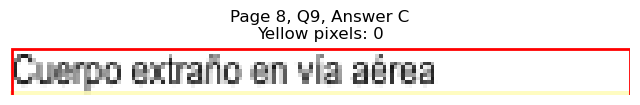

Page 8, Q9 - D: Detected box: x0=327.5, y0=745.8, x1=470.5, y1=758.4
Page 8, Q9, D: Yellow pixels: 1944
Page 8, Q9, D: Total non-white pixels: 2716
Page 8, Q9, D: Yellow percentage: 71.6%


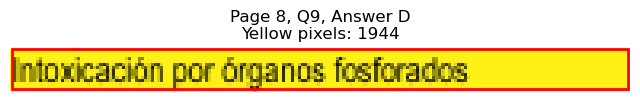


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=117.5, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 259
Page 9, Q1, A: Yellow percentage: 0.0%


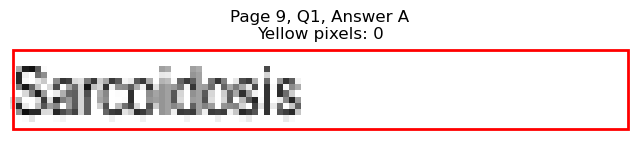

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=147.5, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 397
Page 9, Q1, B: Yellow percentage: 0.0%


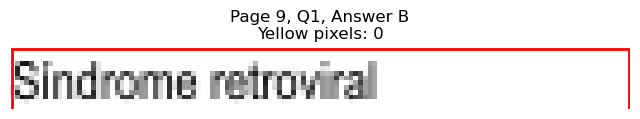

Page 9, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=410.3, y1=127.3
Page 9, Q1, C: Yellow pixels: 1292
Page 9, Q1, C: Total non-white pixels: 1876
Page 9, Q1, C: Yellow percentage: 68.9%


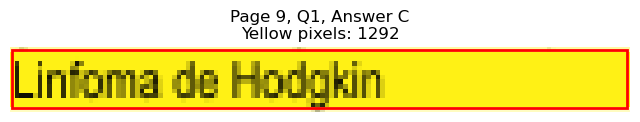

Page 9, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=432.9, y1=139.9
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 700
Page 9, Q1, D: Yellow percentage: 0.0%


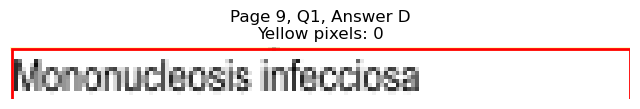


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=120.0, y1=190.4
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 282
Page 9, Q2, A: Yellow percentage: 0.0%


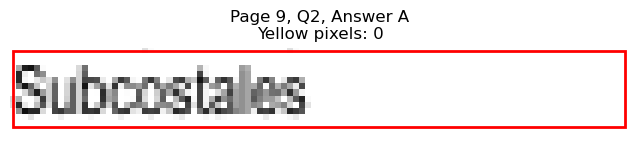

Page 9, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=130.5, y1=203.0
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 306
Page 9, Q2, B: Yellow percentage: 0.0%


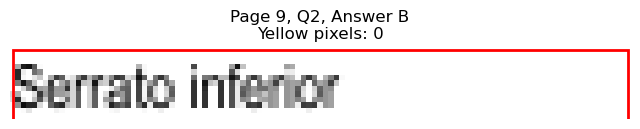

Page 9, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=415.9, y1=190.4
Page 9, Q2, C: Yellow pixels: 139
Page 9, Q2, C: Total non-white pixels: 599
Page 9, Q2, C: Yellow percentage: 23.2%


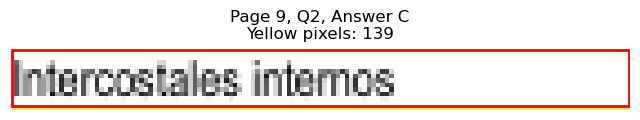

Page 9, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=371.7, y1=203.0
Page 9, Q2, D: Yellow pixels: 1055
Page 9, Q2, D: Total non-white pixels: 1235
Page 9, Q2, D: Yellow percentage: 85.4%


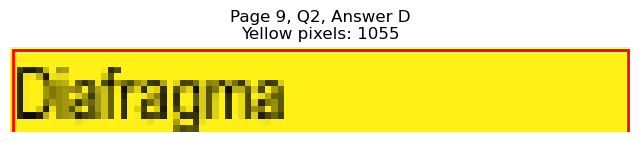


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=96.4, y1=240.9
Page 9, Q3, A: Yellow pixels: 922
Page 9, Q3, A: Total non-white pixels: 1027
Page 9, Q3, A: Yellow percentage: 89.8%


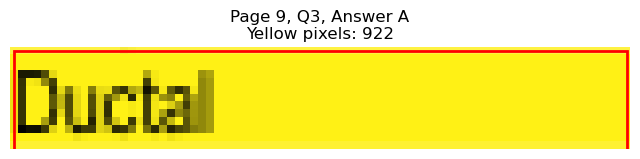

Page 9, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=106.9, y1=253.5
Page 9, Q3, B: Yellow pixels: 89
Page 9, Q3, B: Total non-white pixels: 247
Page 9, Q3, B: Yellow percentage: 36.0%


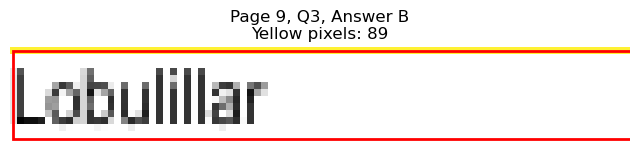

Page 9, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=354.7, y1=240.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 119
Page 9, Q3, C: Yellow percentage: 0.0%


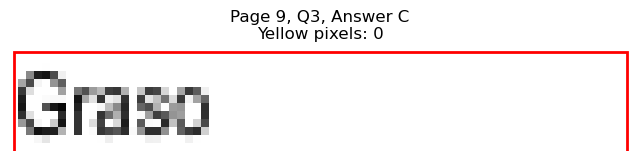

Page 9, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=370.1, y1=253.5
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 211
Page 9, Q3, D: Yellow percentage: 0.0%


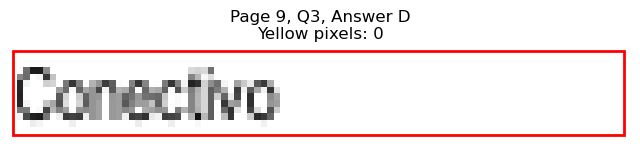


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=190.2, y1=316.7
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 589
Page 9, Q4, A: Yellow percentage: 0.0%


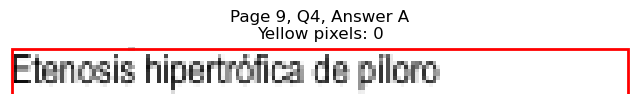

Page 9, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=165.1, y1=329.3
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 542
Page 9, Q4, B: Yellow percentage: 0.0%


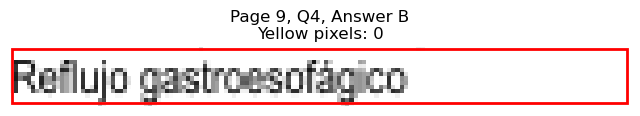

Page 9, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=399.3, y1=316.7
Page 9, Q4, C: Yellow pixels: 1296
Page 9, Q4, C: Total non-white pixels: 1599
Page 9, Q4, C: Yellow percentage: 81.1%


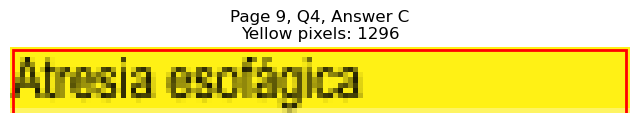

Page 9, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=384.7, y1=329.3
Page 9, Q4, D: Yellow pixels: 107
Page 9, Q4, D: Total non-white pixels: 405
Page 9, Q4, D: Yellow percentage: 26.4%


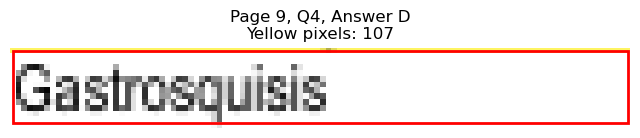


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=139.0, y1=379.8
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 322
Page 9, Q5, A: Yellow percentage: 0.0%


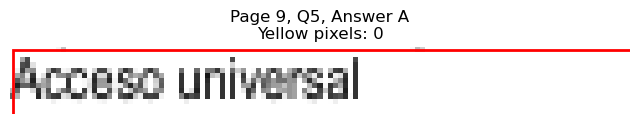

Page 9, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=126.5, y1=392.4
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 300
Page 9, Q5, B: Yellow percentage: 0.0%


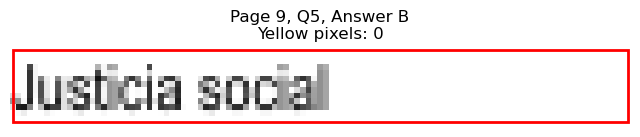

Page 9, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=405.8, y1=379.8
Page 9, Q5, C: Yellow pixels: 2
Page 9, Q5, C: Total non-white pixels: 548
Page 9, Q5, C: Yellow percentage: 0.4%


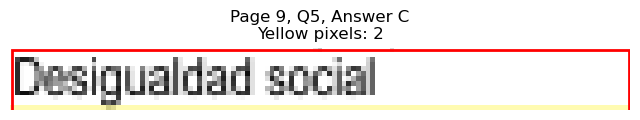

Page 9, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=406.3, y1=392.4
Page 9, Q5, D: Yellow pixels: 1250
Page 9, Q5, D: Total non-white pixels: 1820
Page 9, Q5, D: Yellow percentage: 68.7%


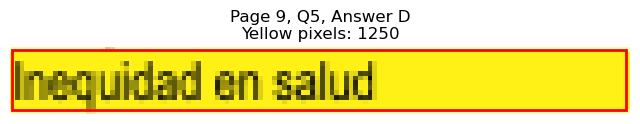


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=117.5, y1=455.5
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 261
Page 9, Q6, A: Yellow percentage: 0.0%


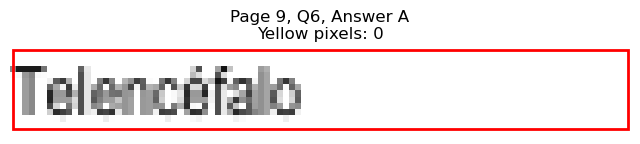

Page 9, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=121.5, y1=468.1
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 308
Page 9, Q6, B: Yellow percentage: 0.0%


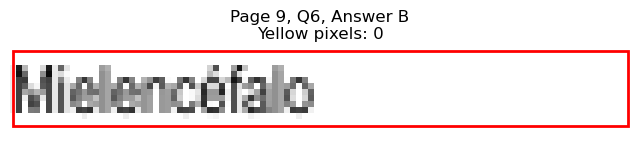

Page 9, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=379.3, y1=455.5
Page 9, Q6, C: Yellow pixels: 103
Page 9, Q6, C: Total non-white pixels: 381
Page 9, Q6, C: Yellow percentage: 27.0%


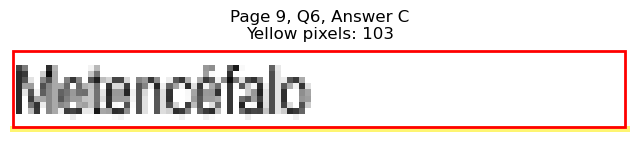

Page 9, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=372.7, y1=468.1
Page 9, Q6, D: Yellow pixels: 1041
Page 9, Q6, D: Total non-white pixels: 1344
Page 9, Q6, D: Yellow percentage: 77.5%


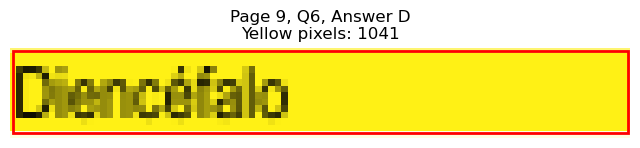


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=119.4, y1=531.2
Page 9, Q7, A: Yellow pixels: 102
Page 9, Q7, A: Total non-white pixels: 359
Page 9, Q7, A: Yellow percentage: 28.4%


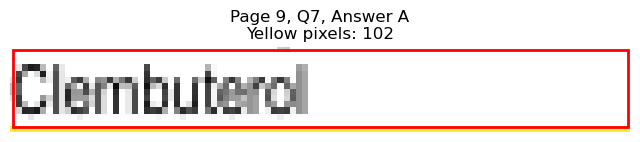

Page 9, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=111.4, y1=543.8
Page 9, Q7, B: Yellow pixels: 1037
Page 9, Q7, B: Total non-white pixels: 1222
Page 9, Q7, B: Yellow percentage: 84.9%


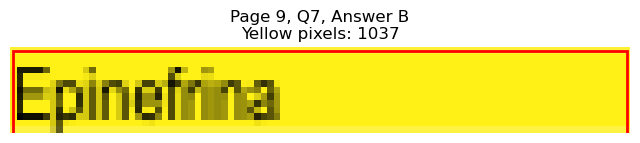

Page 9, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=375.2, y1=531.2
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 237
Page 9, Q7, C: Yellow percentage: 0.0%


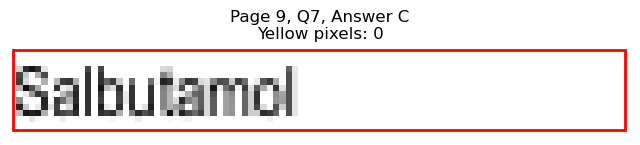

Page 9, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=388.7, y1=543.8
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 324
Page 9, Q7, D: Yellow percentage: 0.0%


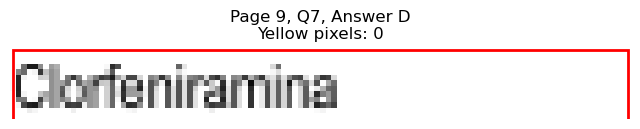


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=171.1, y1=594.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 516
Page 9, Q8, A: Yellow percentage: 0.0%


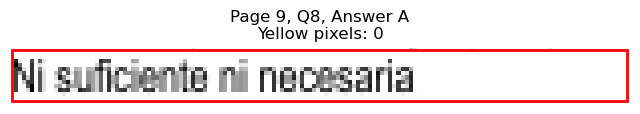

Page 9, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=159.0, y1=607.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 476
Page 9, Q8, B: Yellow percentage: 0.0%


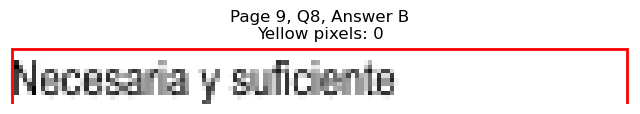

Page 9, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=444.4, y1=594.4
Page 9, Q8, C: Yellow pixels: 1568
Page 9, Q8, C: Total non-white pixels: 2352
Page 9, Q8, C: Yellow percentage: 66.7%


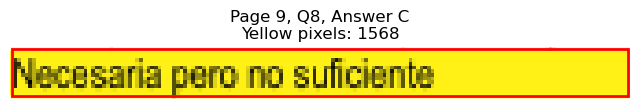

Page 9, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=444.4, y1=607.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 743
Page 9, Q8, D: Yellow percentage: 0.0%


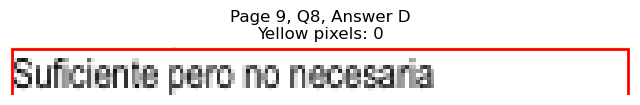


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=119.9, y1=682.7
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 274
Page 9, Q9, A: Yellow percentage: 0.0%


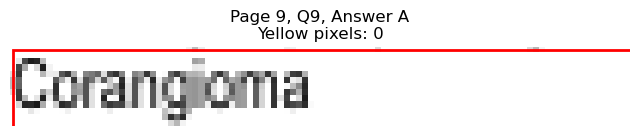

Page 9, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=171.1, y1=695.3
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 545
Page 9, Q9, B: Yellow percentage: 0.0%


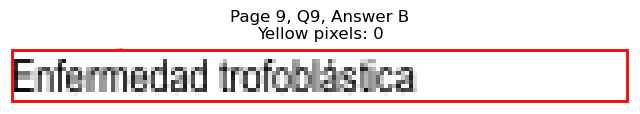

Page 9, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=396.8, y1=682.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 486
Page 9, Q9, C: Yellow percentage: 0.0%


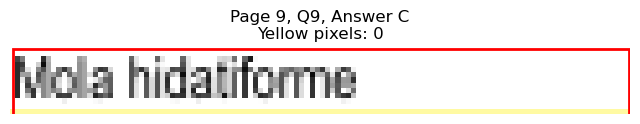

Page 9, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=441.4, y1=695.3
Page 9, Q9, D: Yellow pixels: 1525
Page 9, Q9, D: Total non-white pixels: 2310
Page 9, Q9, D: Yellow percentage: 66.0%


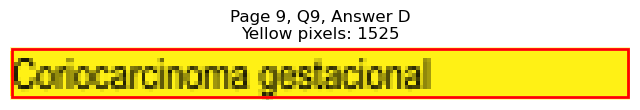


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=118.0, y1=745.8
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 234
Page 9, Q10, A: Yellow percentage: 0.0%


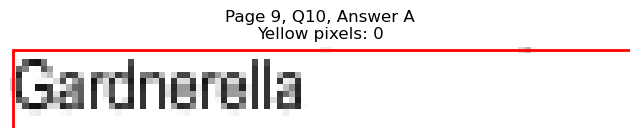

Page 9, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=113.4, y1=758.4
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 241
Page 9, Q10, B: Yellow percentage: 0.0%


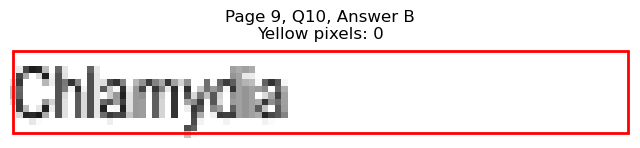

Page 9, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=363.8, y1=745.8
Page 9, Q10, C: Yellow pixels: 972
Page 9, Q10, C: Total non-white pixels: 1131
Page 9, Q10, C: Yellow percentage: 85.9%


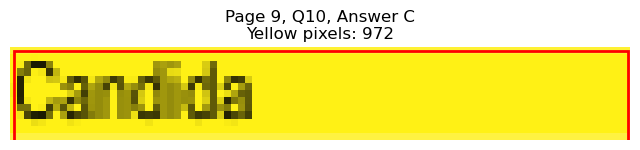

Page 9, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=379.8, y1=758.4
Page 9, Q10, D: Yellow pixels: 103
Page 9, Q10, D: Total non-white pixels: 369
Page 9, Q10, D: Yellow percentage: 27.9%


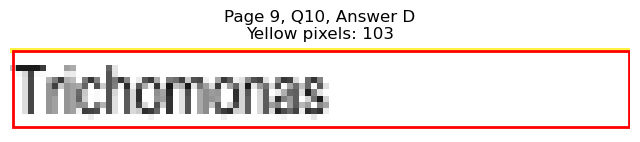


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=121.0, y1=127.3
Page 10, Q1, A: Yellow pixels: 1011
Page 10, Q1, A: Total non-white pixels: 1442
Page 10, Q1, A: Yellow percentage: 70.1%


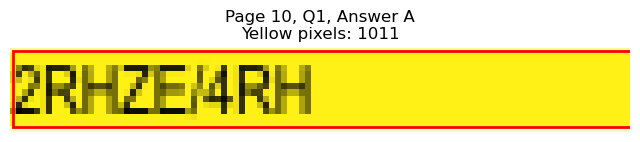

Page 10, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=121.0, y1=139.9
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 377
Page 10, Q1, B: Yellow percentage: 0.0%


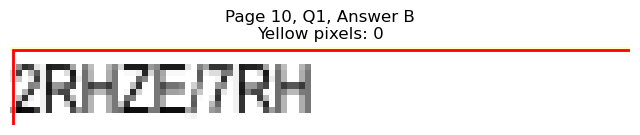

Page 10, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=385.1, y1=127.3
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 294
Page 10, Q1, C: Yellow percentage: 0.0%


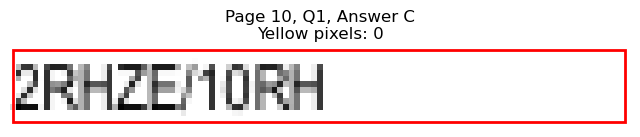

Page 10, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=380.2, y1=139.9
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 280
Page 10, Q1, D: Yellow percentage: 0.0%


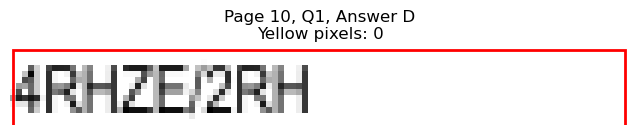


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=121.9, y1=203.0
Page 10, Q2, A: Yellow pixels: 1137
Page 10, Q2, A: Total non-white pixels: 1352
Page 10, Q2, A: Yellow percentage: 84.1%


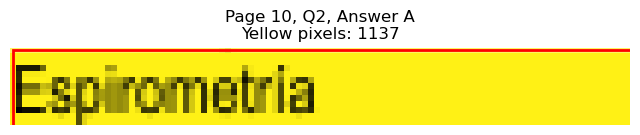

Page 10, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=152.1, y1=215.6
Page 10, Q2, B: Yellow pixels: 134
Page 10, Q2, B: Total non-white pixels: 540
Page 10, Q2, B: Yellow percentage: 24.8%


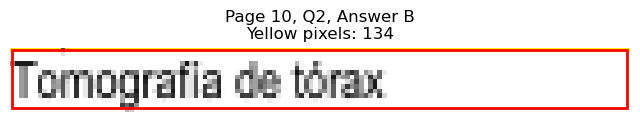

Page 10, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=404.8, y1=203.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 400
Page 10, Q2, C: Yellow percentage: 0.0%


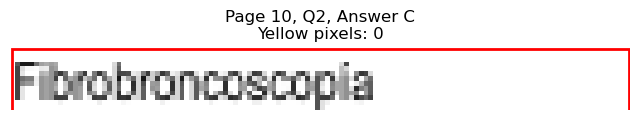

Page 10, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=368.1, y1=215.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 172
Page 10, Q2, D: Yellow percentage: 0.0%


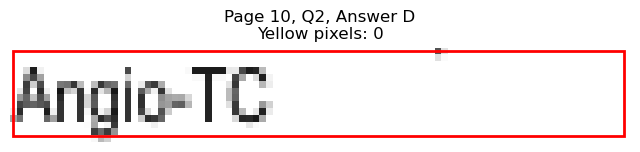


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=156.0, y1=291.5
Page 10, Q3, A: Yellow pixels: 1444
Page 10, Q3, A: Total non-white pixels: 1946
Page 10, Q3, A: Yellow percentage: 74.2%


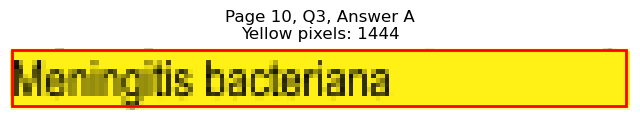

Page 10, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=160.6, y1=304.1
Page 10, Q3, B: Yellow pixels: 142
Page 10, Q3, B: Total non-white pixels: 644
Page 10, Q3, B: Yellow percentage: 22.0%


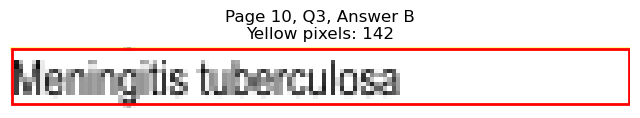

Page 10, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=402.3, y1=291.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 419
Page 10, Q3, C: Yellow percentage: 0.0%


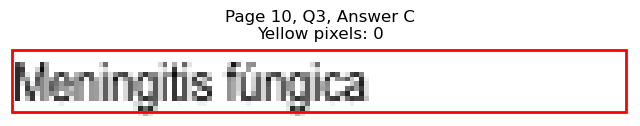

Page 10, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=390.2, y1=304.1
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 331
Page 10, Q3, D: Yellow percentage: 0.0%


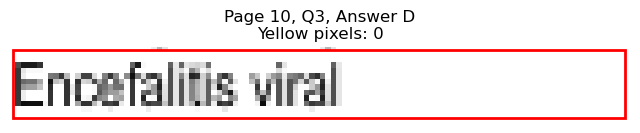


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=132.0, y1=367.2
Page 10, Q4, A: Yellow pixels: 1247
Page 10, Q4, A: Total non-white pixels: 1610
Page 10, Q4, A: Yellow percentage: 77.5%


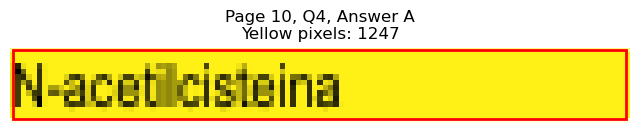

Page 10, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=109.0, y1=379.8
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 295
Page 10, Q4, B: Yellow percentage: 0.0%


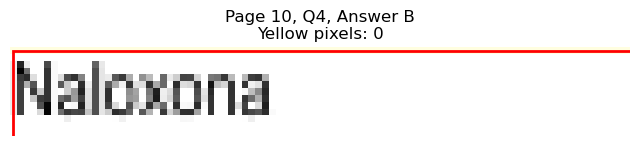

Page 10, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=390.8, y1=367.2
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 344
Page 10, Q4, C: Yellow percentage: 0.0%


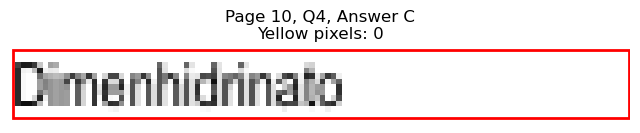

Page 10, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=374.2, y1=379.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 234
Page 10, Q4, D: Yellow percentage: 0.0%


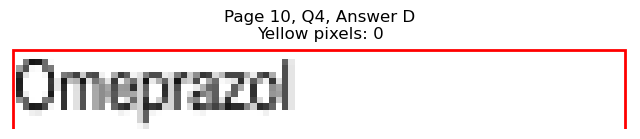


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=120.0, y1=430.3
Page 10, Q5, A: Yellow pixels: 103
Page 10, Q5, A: Total non-white pixels: 360
Page 10, Q5, A: Yellow percentage: 28.6%


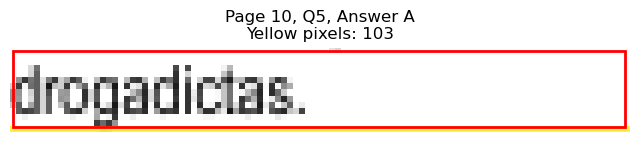

Page 10, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=115.9, y1=442.9
Page 10, Q5, B: Yellow pixels: 1118
Page 10, Q5, B: Total non-white pixels: 1274
Page 10, Q5, B: Yellow percentage: 87.8%


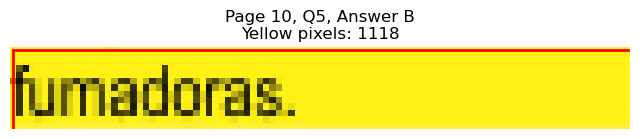

Page 10, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=369.2, y1=430.3
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 210
Page 10, Q5, C: Yellow percentage: 0.0%


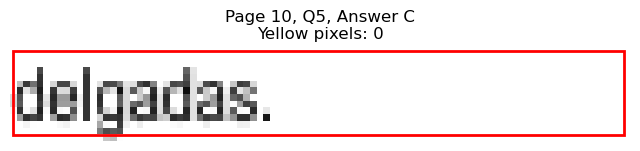

Page 10, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=377.2, y1=442.9
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 246
Page 10, Q5, D: Yellow percentage: 0.0%


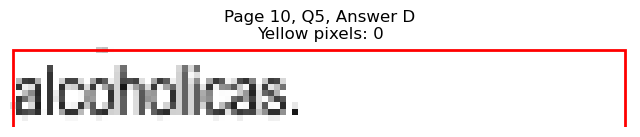


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=116.4, y1=518.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 269
Page 10, Q6, A: Yellow percentage: 0.0%


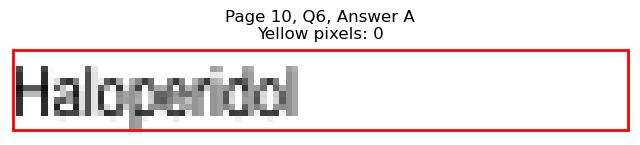

Page 10, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=116.4, y1=531.2
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 249
Page 10, Q6, B: Yellow percentage: 0.0%


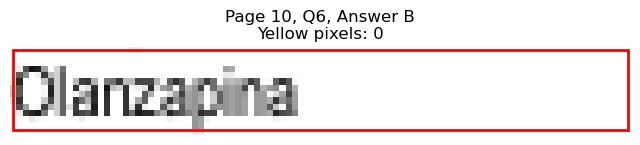

Page 10, Q6 - C: Detected box: x0=327.5, y0=506.0, x1=370.6, y1=518.6
Page 10, Q6, C: Yellow pixels: 1052
Page 10, Q6, C: Total non-white pixels: 1316
Page 10, Q6, C: Yellow percentage: 79.9%


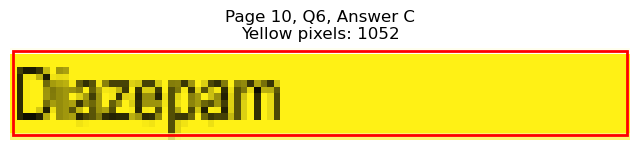

Page 10, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=388.7, y1=531.2
Page 10, Q6, D: Yellow pixels: 112
Page 10, Q6, D: Total non-white pixels: 429
Page 10, Q6, D: Yellow percentage: 26.1%


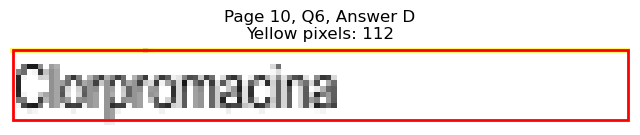


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=100.5, y1=581.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 123
Page 10, Q7, A: Yellow percentage: 0.0%


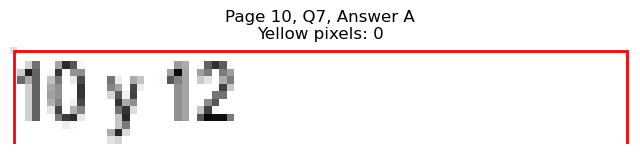

Page 10, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=95.4, y1=594.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 107
Page 10, Q7, B: Yellow percentage: 0.0%


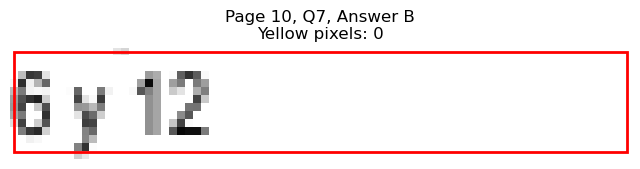

Page 10, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=359.8, y1=581.8
Page 10, Q7, C: Yellow pixels: 985
Page 10, Q7, C: Total non-white pixels: 1079
Page 10, Q7, C: Yellow percentage: 91.3%


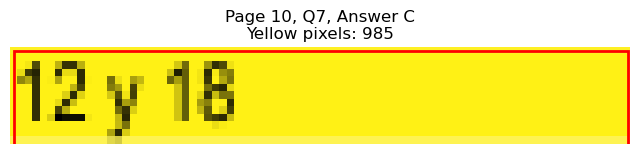

Page 10, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=359.7, y1=594.4
Page 10, Q7, D: Yellow pixels: 83
Page 10, Q7, D: Total non-white pixels: 199
Page 10, Q7, D: Yellow percentage: 41.7%


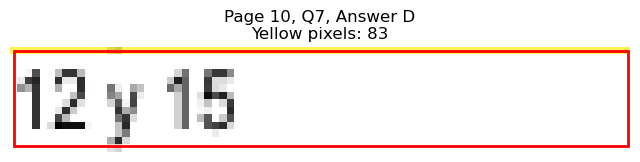


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=181.1, y1=657.5
Page 10, Q8, A: Yellow pixels: 1660
Page 10, Q8, A: Total non-white pixels: 2296
Page 10, Q8, A: Yellow percentage: 72.3%


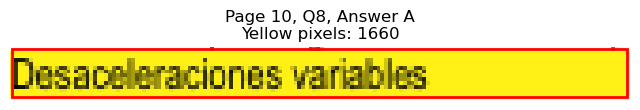

Page 10, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=137.5, y1=670.1
Page 10, Q8, B: Yellow pixels: 120
Page 10, Q8, B: Total non-white pixels: 471
Page 10, Q8, B: Yellow percentage: 25.5%


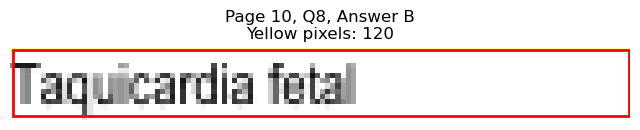

Page 10, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=431.8, y1=657.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 558
Page 10, Q8, C: Yellow percentage: 0.0%


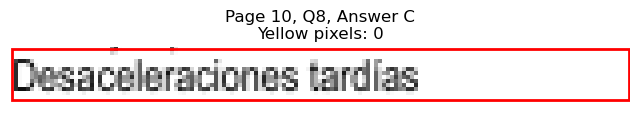

Page 10, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=446.9, y1=670.1
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 599
Page 10, Q8, D: Yellow percentage: 0.0%


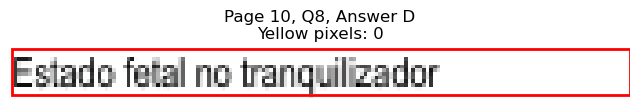


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=144.5, y1=720.6
Page 10, Q9, A: Yellow pixels: 127
Page 10, Q9, A: Total non-white pixels: 497
Page 10, Q9, A: Yellow percentage: 25.6%


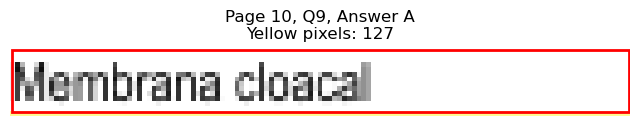

Page 10, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=178.1, y1=733.2
Page 10, Q9, B: Yellow pixels: 1611
Page 10, Q9, B: Total non-white pixels: 2254
Page 10, Q9, B: Yellow percentage: 71.5%


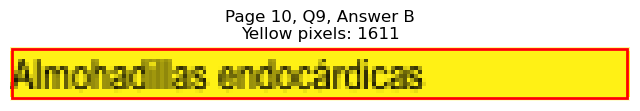

Page 10, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=403.7, y1=720.6
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 393
Page 10, Q9, C: Yellow percentage: 0.0%


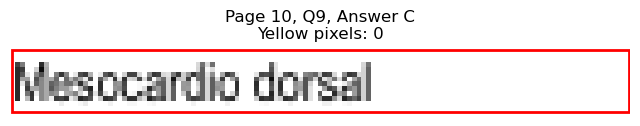

Page 10, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=425.9, y1=733.2
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 520
Page 10, Q9, D: Yellow percentage: 0.0%


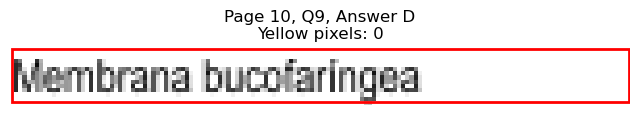


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=136.0, y1=114.7
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 327
Page 11, Q1, A: Yellow percentage: 0.0%


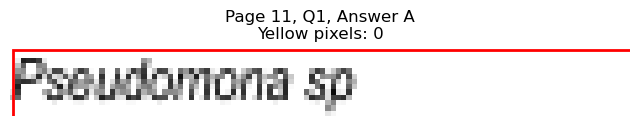

Page 11, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=157.1, y1=127.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 450
Page 11, Q1, B: Yellow percentage: 0.0%


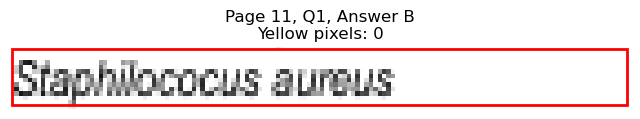

Page 11, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=420.8, y1=114.7
Page 11, Q1, C: Yellow pixels: 1
Page 11, Q1, C: Total non-white pixels: 636
Page 11, Q1, C: Yellow percentage: 0.2%


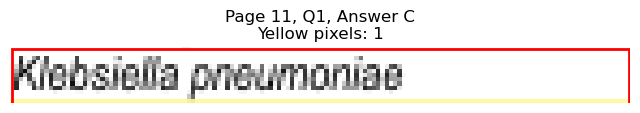

Page 11, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=439.4, y1=127.3
Page 11, Q1, D: Yellow pixels: 1518
Page 11, Q1, D: Total non-white pixels: 2282
Page 11, Q1, D: Yellow percentage: 66.5%


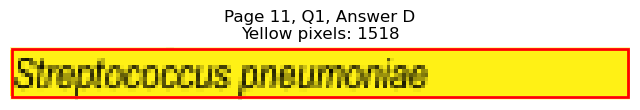


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=135.5, y1=190.4
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 346
Page 11, Q2, A: Yellow percentage: 0.0%


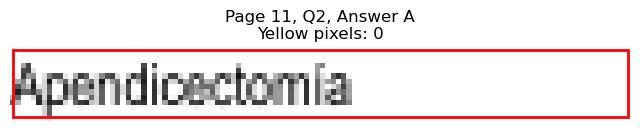

Page 11, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=112.5, y1=203.0
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 228
Page 11, Q2, B: Yellow percentage: 0.0%


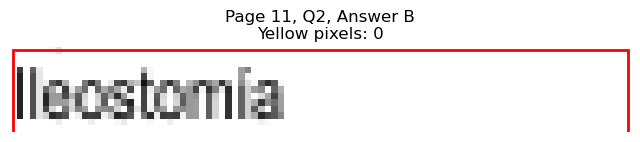

Page 11, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=429.9, y1=190.4
Page 11, Q2, C: Yellow pixels: 1417
Page 11, Q2, C: Total non-white pixels: 2142
Page 11, Q2, C: Yellow percentage: 66.2%


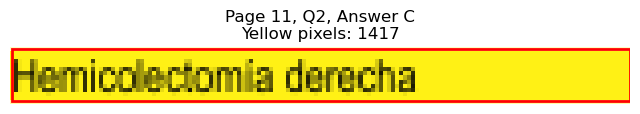

Page 11, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=445.4, y1=203.0
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 754
Page 11, Q2, D: Yellow percentage: 0.0%


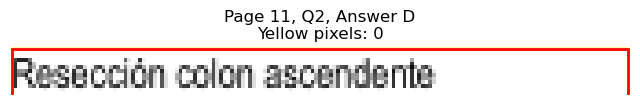


Page 11, Q2 - Selected Answer: C (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=146.5, y1=278.7
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 433
Page 11, Q3, A: Yellow percentage: 0.0%


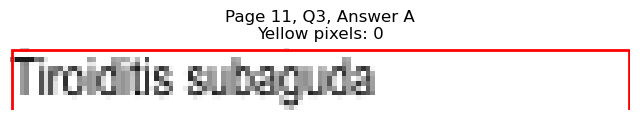

Page 11, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=136.0, y1=291.5
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 335
Page 11, Q3, B: Yellow percentage: 0.0%


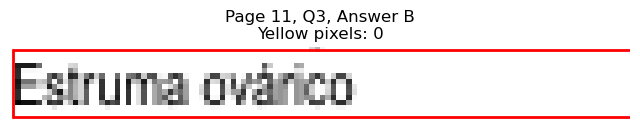

Page 11, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=429.3, y1=278.7
Page 11, Q3, C: Yellow pixels: 1566
Page 11, Q3, C: Total non-white pixels: 1989
Page 11, Q3, C: Yellow percentage: 78.7%


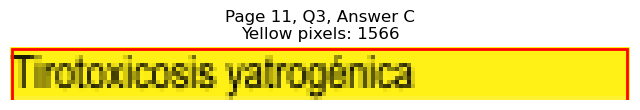

Page 11, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=423.3, y1=291.5
Page 11, Q3, D: Yellow pixels: 145
Page 11, Q3, D: Total non-white pixels: 621
Page 11, Q3, D: Yellow percentage: 23.3%


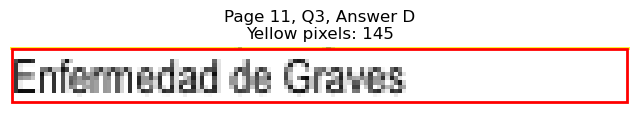


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=142.6, y1=341.9
Page 11, Q4, A: Yellow pixels: 1326
Page 11, Q4, A: Total non-white pixels: 1625
Page 11, Q4, A: Yellow percentage: 81.6%


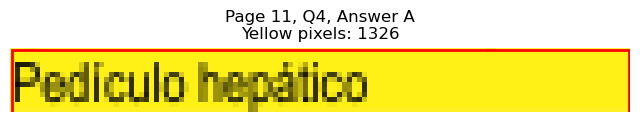

Page 11, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=169.1, y1=354.6
Page 11, Q4, B: Yellow pixels: 150
Page 11, Q4, B: Total non-white pixels: 651
Page 11, Q4, B: Yellow percentage: 23.0%


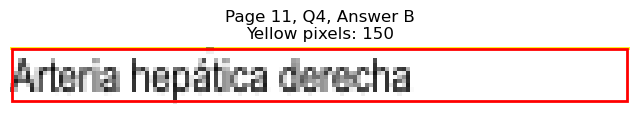

Page 11, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=374.2, y1=341.9
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 210
Page 11, Q4, C: Yellow percentage: 0.0%


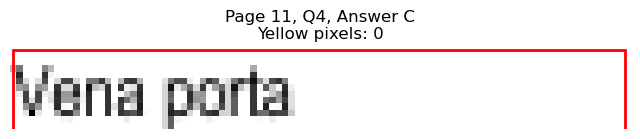

Page 11, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=403.3, y1=354.6
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 354
Page 11, Q4, D: Yellow percentage: 0.0%


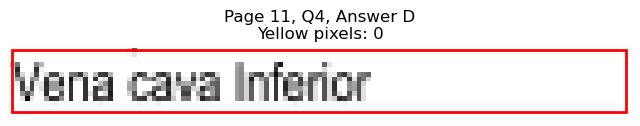


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=153.5, y1=392.4
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 459
Page 11, Q5, A: Yellow percentage: 0.0%


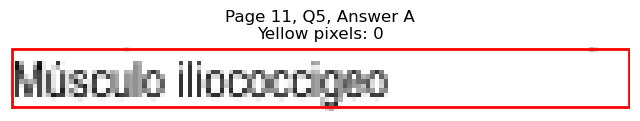

Page 11, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=172.1, y1=405.0
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 549
Page 11, Q5, B: Yellow percentage: 0.0%


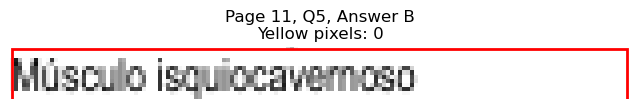

Page 11, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=394.3, y1=392.4
Page 11, Q5, C: Yellow pixels: 118
Page 11, Q5, C: Total non-white pixels: 458
Page 11, Q5, C: Yellow percentage: 25.8%


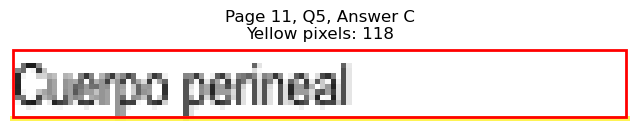

Page 11, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=429.4, y1=405.0
Page 11, Q5, D: Yellow pixels: 1563
Page 11, Q5, D: Total non-white pixels: 1989
Page 11, Q5, D: Yellow percentage: 78.6%


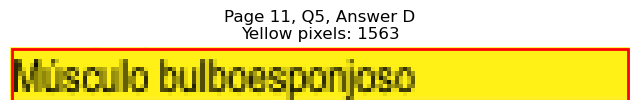


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=112.9, y1=455.5
Page 11, Q6, A: Yellow pixels: 1077
Page 11, Q6, A: Total non-white pixels: 1330
Page 11, Q6, A: Yellow percentage: 81.0%


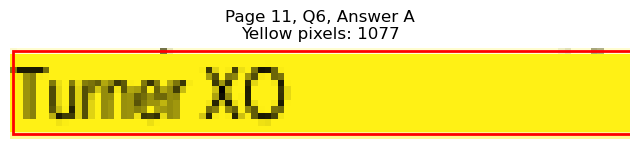

Page 11, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=112.0, y1=468.1
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 192
Page 11, Q6, B: Yellow percentage: 0.0%


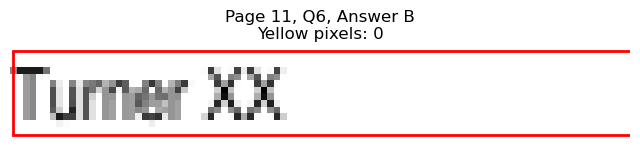

Page 11, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=376.1, y1=455.5
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 246
Page 11, Q6, C: Yellow percentage: 0.0%


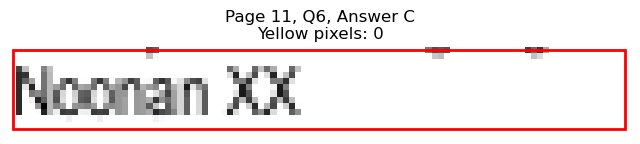

Page 11, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=412.3, y1=468.1
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 433
Page 11, Q6, D: Yellow percentage: 0.0%


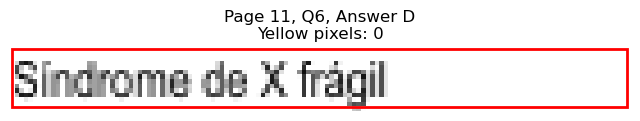


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=216.5, y1=518.6
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 728
Page 11, Q7, A: Yellow percentage: 0.0%


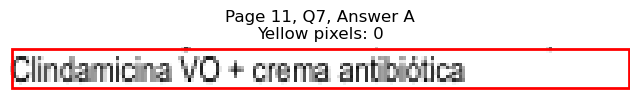

Page 11, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=208.0, y1=531.2
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 641
Page 11, Q7, B: Yellow percentage: 0.0%


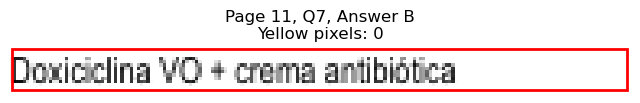

Page 11, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=506.9, y1=518.6
Page 11, Q7, C: Yellow pixels: 2098
Page 11, Q7, C: Total non-white pixels: 2995
Page 11, Q7, C: Yellow percentage: 70.1%


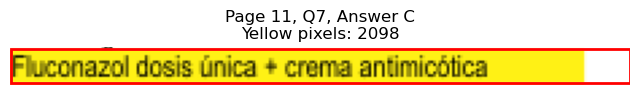

Page 11, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=439.9, y1=531.2
Page 11, Q7, D: Yellow pixels: 163
Page 11, Q7, D: Total non-white pixels: 726
Page 11, Q7, D: Yellow percentage: 22.5%


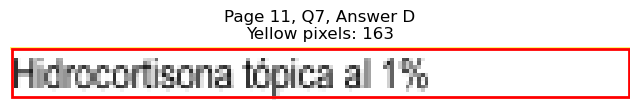


Page 11, Q7 - Selected Answer: C (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=129.5, y1=594.4
Page 11, Q8, A: Yellow pixels: 112
Page 11, Q8, A: Total non-white pixels: 411
Page 11, Q8, A: Yellow percentage: 27.3%


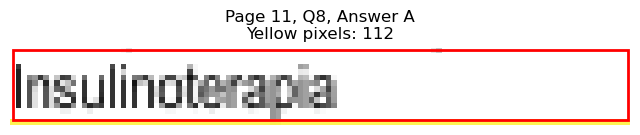

Page 11, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=155.5, y1=607.0
Page 11, Q8, B: Yellow pixels: 1424
Page 11, Q8, B: Total non-white pixels: 1794
Page 11, Q8, B: Yellow percentage: 79.4%


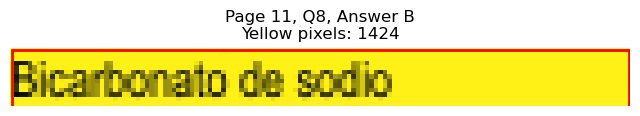

Page 11, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=402.8, y1=594.4
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 373
Page 11, Q8, C: Yellow percentage: 0.0%


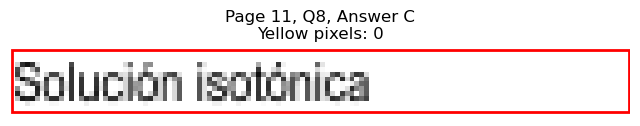

Page 11, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=389.7, y1=607.0
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 324
Page 11, Q8, D: Yellow percentage: 0.0%


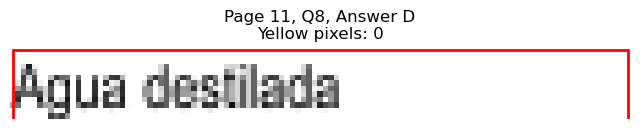


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=80.9, y1=657.5
Page 11, Q9, A: Yellow pixels: 0
Page 11, Q9, A: Total non-white pixels: 53
Page 11, Q9, A: Yellow percentage: 0.0%


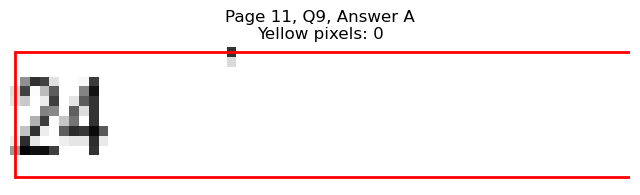

Page 11, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=80.9, y1=670.1
Page 11, Q9, B: Yellow pixels: 0
Page 11, Q9, B: Total non-white pixels: 58
Page 11, Q9, B: Yellow percentage: 0.0%


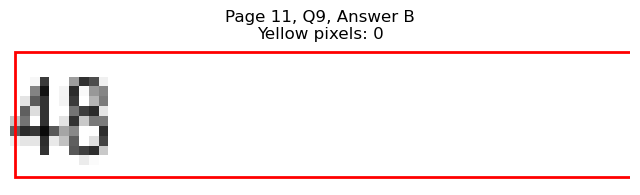

Page 11, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=340.1, y1=657.5
Page 11, Q9, C: Yellow pixels: 64
Page 11, Q9, C: Total non-white pixels: 110
Page 11, Q9, C: Yellow percentage: 58.2%


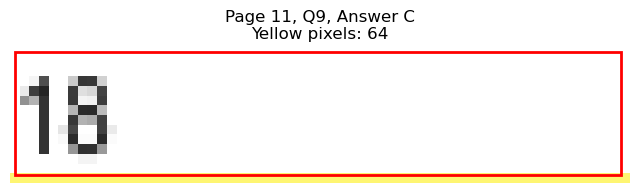

Page 11, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=342.7, y1=670.1
Page 11, Q9, D: Yellow pixels: 825
Page 11, Q9, D: Total non-white pixels: 924
Page 11, Q9, D: Yellow percentage: 89.3%


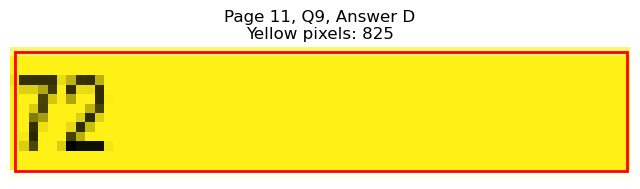


Page 11, Q9 - Selected Answer: D (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 26 años, sufre accidente automovilíst...
1   Niño de 2 años con fiebre y otalgia izquierda ...
2   Varón de 25 años, quien ingiere sustancia que ...
3   Lactante de 8 meses, presenta lesiones cutánea...
4   Respecto a la evaluación del bienestar del fet...
..                                                ...
95  En una episiotomía medio lateral. ¿Qué estruct...
96  Niña de 8 años traída a consulta por talla baj...
97  Adolescente de 14 años acude por presentar pru...
98  Mujer de 35 años, ingresa por vómitos, dolor a...
99  En relación a la vacuna contra la varicela. ¿H...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                            option_B  \
0               Lesión primaria de SRAA          Disfunción cerebral difusa   
1                                    20                                   5   
2                                Etanol                         Flumazenilo   
3                       Ictiosis vulgar               Dermatitis seborreica   
4                       Test estresante                   Líquido amniótico   
..                                  ...                                 ...   
95                 Músculo iliococcigeo             Músculo isquiocavernoso   
96                            Turner XO                           Turner XX   
97  Clindamicina VO + crema antibiótica  Doxiciclina VO + crema antibiótica   
98                      Insulinoterapia                Bicarbonato de sodio   
99                                   24                                  48   

                                       option_C  \
0                       Inconsciencia psicógena   
1                                            10   
2                                      Atropina   
3                            Dermatitis atópica   
4                          Fllujometría Doppler   
..                                          ...   
95                              Cuerpo perineal   
96                                    Noonan XX   
97  Fluconazol dosis única + crema antimicótica   
98                           Solución isotónica   
99                                           18   

                                     option_D  
0   Lesión hemisférica con herniación troncal  
1                                           7  
2                                  Adrenalina  
3                              Eccema numular  
4                            Edad gestacional  
..                                        ...  
95                     Músculo bulboesponjoso  
96                       Síndrome de X frágil  
97                Hidrocortisona tópica al 1%  
98                             Agua destilada  
99                                         72  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               C
2               A
3               C
4               B
..            ...
95              D
96              A
97              C
98              B
99              D

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 26 años, sufre accidente automovilíst...   
1   Niño de 2 años con fiebre y otalgia izquierda ...   
2   Varón de 25 años, quien ingiere sustancia que ...   
3   Lactante de 8 meses, presenta lesiones cutánea...   
4   Respecto a la evaluación del bienestar del fet...   
..                                                ...   
95  En una episiotomía medio lateral. ¿Qué estruct...   
96  Niña de 8 años traída a consulta por talla baj...   
97  Adolescente de 14 años acude por presentar pru...   
98  Mujer de 35 años, ingresa por vómitos, dolor a...   
99  En relación a la vacuna contra la varicela. ¿H...   

                               option_A                            option_B  \
0               Lesión primaria de SRAA          Disfunción cerebral difusa   
1                                    20                                   5   
2                                Etanol                         Flumazenilo   
3                       Ictiosis vulgar               Dermatitis seborreica   
4                       Test estresante                   Líquido amniótico   
..                                  ...                                 ...   
95                 Músculo iliococcigeo             Músculo isquiocavernoso   
96                            Turner XO                           Turner XX   
97  Clindamicina VO + crema antibiótica  Doxiciclina VO + crema antibiótica   
98                      Insulinoterapia                Bicarbonato de sodio   
99                                   24                                  48   

                                       option_C  \
0                       Inconsciencia psicógena   
1                                            10   
2                                      Atropina   
3                            Dermatitis atópica   
4                          Fllujometría Doppler   
..                                          ...   
95                              Cuerpo perineal   
96                                    Noonan XX   
97  Fluconazol dosis única + crema antimicótica   
98                           Solución isotónica   
99                                           18   

                                     option_D correct_answer  
0   Lesión hemisférica con herniación troncal              D  
1                                           7              C  
2                                  Adrenalina              A  
3                              Eccema numular              C  
4                            Edad gestacional              B  
..                                        ...            ...  
95                     Músculo bulboesponjoso              D  
96                       Síndrome de X frágil              A  
97                Hidrocortisona tópica al 1%              C  
98                             Agua destilada              B  
99                                         72              D  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/PRUEBA A.csv
